From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [1]:
#import libraries and scripts

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils

#imports to get rid of Morgan Fingerprint warnings
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

#set seaborn palette
sns.set_palette('colorblind')

We import the reduced dataset with the custom dataloader `get_dataset`. The reduced dataset contains only viruses responsible for STDs as target organisms

In [2]:
#read the std database

df = get_dataset()
print(f'STDs dataset rows: {df.shape[0]}')
print(f'STDs dataset columns: {df.shape[1]}')

STDs dataset rows: 30156
STDs dataset columns: 86


In the dataset, four affinity metric are available:

1. **Ki (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **IC50 (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **Kd (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **EC50 (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between **Ki** and **IC50**, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided.

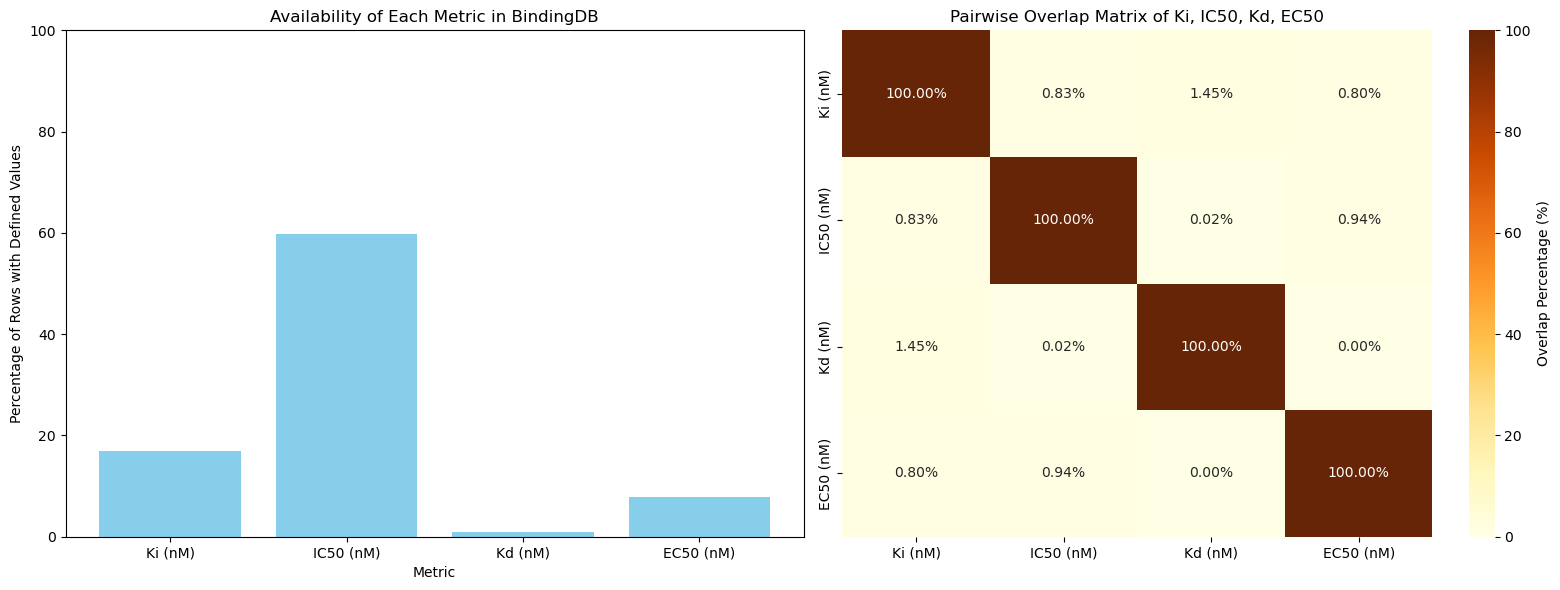

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes.flatten()

evaluation_utils.plot_metric_availability(df, ax=ax[0])
evaluation_utils.plot_overlap_matrix(df, ax=ax[1])

plt.tight_layout()
plt.show()

We observe that IC50 is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with IC50 for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.



In [4]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
print(f'Rows of STD dataset where IC50 is given: {df.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {df.shape[1]}')

Rows of STD dataset where IC50 is given: 18026
Columns of STD dataset where nan rows are less than 50% of the total: 27


To have a first look at the IC50 values across the organisms, we use the `evalutation_utils.plot_ic50_boxplots` function to generate boxplots of the metric across different targets.   
We selected only viruses with at least 20 entries to obtain significant results and used a logarithmic scale.

##

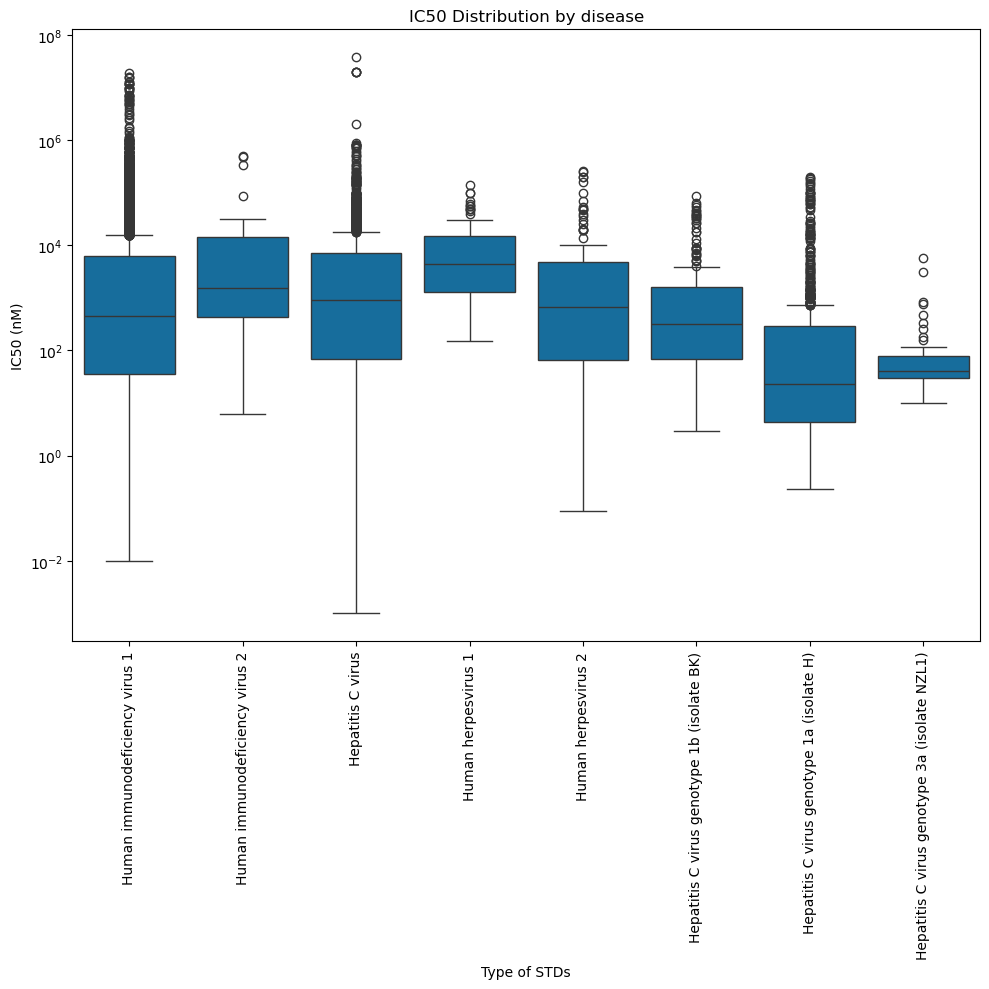

In [5]:
###box plot to see the distribution of ic50 in each type of stds

evaluation_utils.plot_ic50_boxplots(df)

Let's now plot with the `evaluation_utils.plot_organism_counts` function the frequencies of entries for all targets. The distribution we obtain is skewed, so we employ again a logarithmic scale

In [6]:
df['Target Source Organism According to Curator or DataSource'].value_counts()

Target Source Organism According to Curator or DataSource
Human immunodeficiency virus 1                                        13754
Hepatitis C virus                                                      2843
Hepatitis C virus genotype 1a (isolate H)                               903
Hepatitis C virus genotype 1b (isolate BK)                              201
Human herpesvirus 2                                                     114
Human herpesvirus 1                                                      77
Hepatitis C virus genotype 3a (isolate NZL1)                             45
Human immunodeficiency virus 2                                           36
Human T-lymphotropic virus 1                                             18
Hepatitis C virus genotype 2b (isolate HC-J8)                            13
Human immunodeficiency virus type 1 group M subtype B (isolate MN)       10
Hepatitis C virus genotype 1b (isolate Taiwan)                            6
Human herpesvirus 8           

In [7]:
def plot_organism_counts_pie(df):
    ### let's see how STDs are distributed
    # Count the number of occurrences for each type of disease
    counts = df['Target Source Organism According to Curator or DataSource'].value_counts()
    counts = counts[:6]
    #counts = orgc.value_counts()
    plt.figure(figsize=(12, 12))

    # Plot the pie chart
    plot = counts.plot.pie(figsize=(15, 15), autopct='%1.1f%%')


    plt.ylabel('')  # Optional: Remove y-axis label for better visualization
    plt.show()

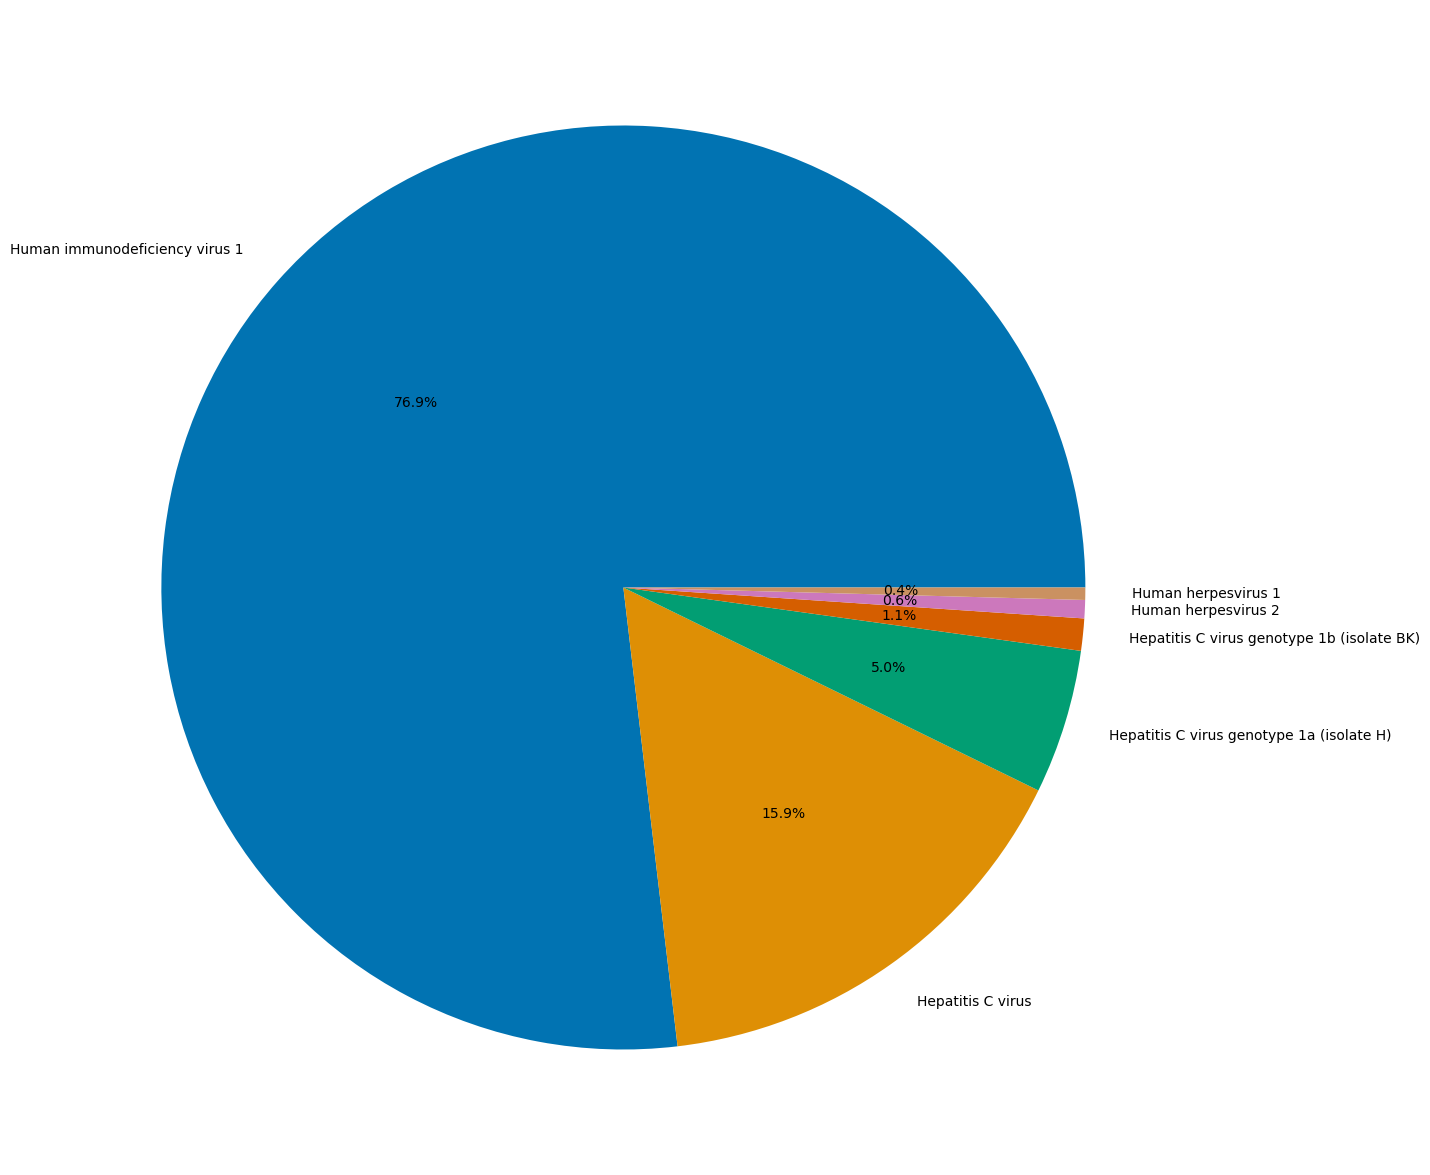

In [8]:
plot_organism_counts_pie(df)

We observe that HIV 1 is clearly the most represented in the dataset (this type accounts for more than 95% of HIV infections worldwide (see https://doi.org/10.1093/infdis/jiad327)).  

For this preliminar analysis, we will focus on the HIV 1 subset of STD.  
Let's create a new `hiv` dataframe, containing only rows where the target is `Human immunodeficiency virus 1`

In [9]:
hiv = df[df['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
print(f'HIV1 dataset rows: {hiv.shape[0]}')
print(f'HIV1 dataset columns: {hiv.shape[1]}')

HIV1 dataset rows: 13754
HIV1 dataset columns: 27


Through http requests, we obtain the publication year for each DOI in the dataset

In [ ]:
#create new df containing the DOI's
hiv_doi = hiv.copy()
doi_df = hiv_doi['Article DOI'].value_counts().reset_index()
# Applying  function 'get_publication_year' to each DOI in the dataframe:
doi_df['year'] = doi_df['Article DOI'].apply(lambda x : data_utils.get_publication_year(x))
doi_df
##merging the dataset to have a column contain the year
hiv_doi = pd.merge(hiv_doi, doi_df, on='Article DOI', how='outer')

Given the pandemic outbreak of HIV in the 1980s, it would be insightful to examine its temporal progression. Let's conduct a preliminary analysis to understand how the number of publications has evolved over time, providing an initial glimpse into the trends.

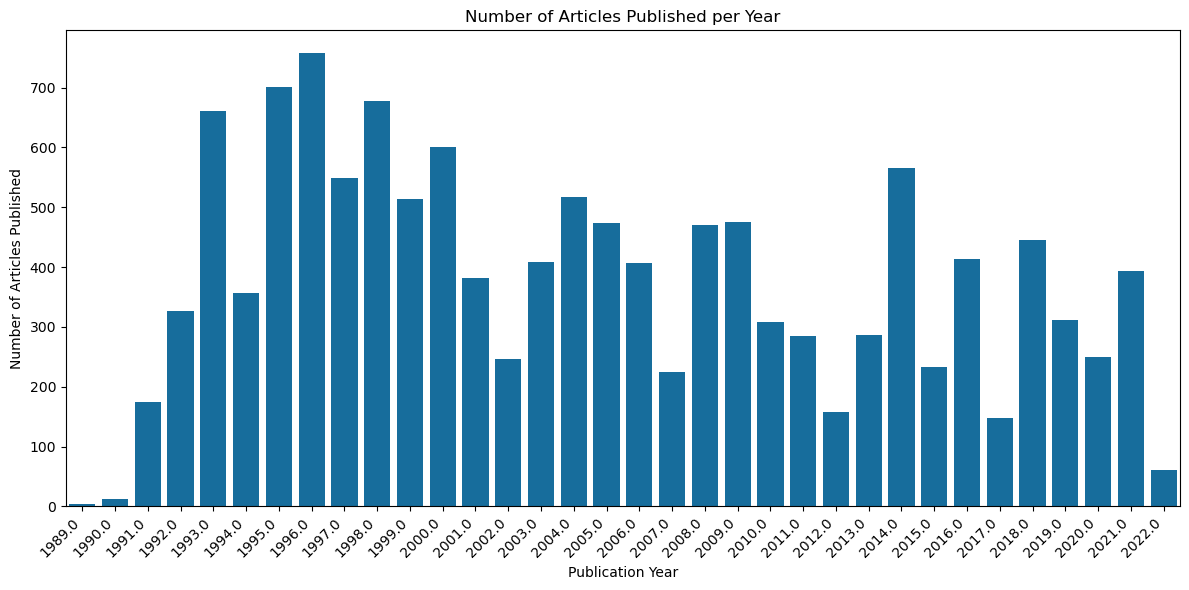

In [11]:
evaluation_utils.plot_publications_per_year(hiv_doi)

### Targets and drug classes analysis
In the previous section we analyzed macro-factors, such as the distribution of publications on HIV-1 across the years. We will now shift our focus on better understanding which types of drugs have been studied in the fight against HIV-1, and their targets.  
To begin, let's have a look at the most targeted proteins:

In [53]:
hiv['Target Name'] = hiv['Target Name'].str.replace("Dimer of ", "", regex=False)
hiv['Target Name'] = hiv['Target Name'].str.replace("Reverse transcriptase protein", "Reverse transcriptase", regex=False)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning) #ignore warning
hivGagPol = hiv[hiv['Target Name'].str.contains('Gag-Pol', na=False)]
hiv_condensed = hiv.copy()
hiv_condensed['Target Name'] = hiv['Target Name'].apply(lambda x: 'Gag-Pol polyprotein' if 'Gag-Pol' in x else x)

In [56]:
hiv_condensed['Target Name'].value_counts()

Target Name
Gag-Pol polyprotein             5201
Reverse transcriptase           3492
Reverse transcriptase/RNaseH    2516
Integrase                       2279
Envelope glycoprotein gp160      200
Protein Rev                       62
Protein Rev [8-24]                 4
Name: count, dtype: int64

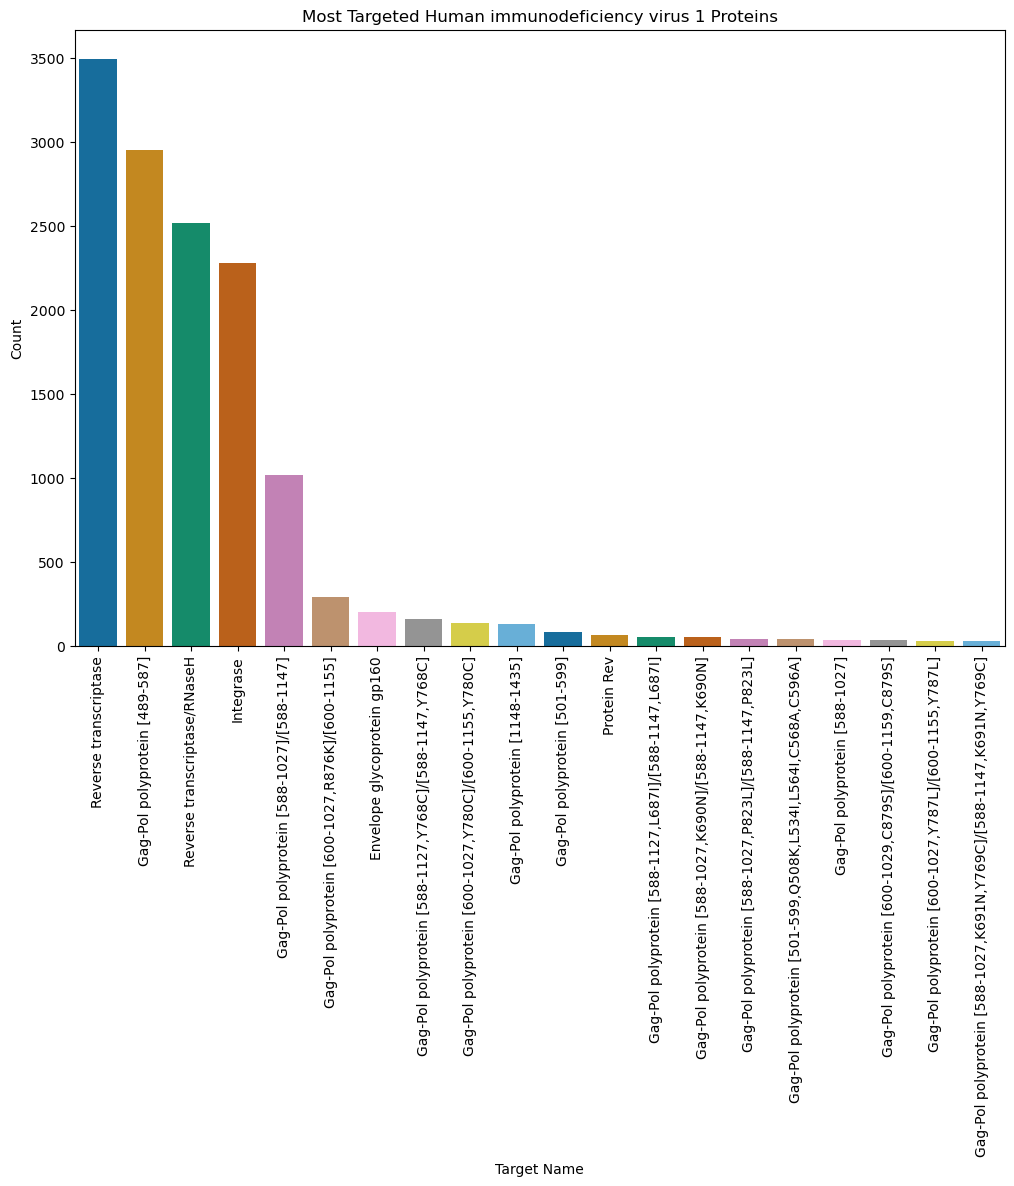

In [12]:
evaluation_utils.plot_most_targeted_proteins(hiv)

### Targeted HIV-1 Proteins

We clearly see that the most targeted proteins in HIV-1 are:

- **Reverse transcriptase**
- **Gag-Pol polyprotein**
- **Integrase**

#### Reverse Transcriptase
Reverse transcriptase is an enzyme that plays a critical role in the HIV lifecycle by converting the virus's single-stranded RNA genome into double-stranded DNA once the virus enters a host cell. This conversion allows the viral DNA to integrate into the host’s genome, a necessary step for HIV replication.

Due to its essential function, reverse transcriptase is a major target for antiretroviral drugs. Two primary classes of inhibitors target this enzyme:
- **Nucleoside Reverse Transcriptase Inhibitors (NRTIs)**: These drugs mimic DNA building blocks, causing premature termination of the DNA chain and stopping HIV replication.
- **Non-Nucleoside Reverse Transcriptase Inhibitors (NNRTIs)**: These drugs bind directly to reverse transcriptase, blocking its activity by altering the enzyme's shape.

#### Gag-Pol Polyprotein
The Gag-Pol polyprotein is a precursor protein produced from the HIV genome that contains multiple essential viral components, including reverse transcriptase, protease, and integrase. During viral maturation, the Gag-Pol polyprotein is cleaved into its functional proteins by the **protease** enzyme, allowing the formation of mature, infectious viral particles.

**Protease inhibitors** are a class of antiretroviral drugs that specifically target the protease enzyme within the Gag-Pol polyprotein. By inhibiting protease, these drugs prevent the cleavage of Gag-Pol, halting the maturation of new viral particles and rendering them non-infectious.

#### Integrase
Integrase is another enzyme within the Gag-Pol polyprotein that facilitates the integration of HIV's DNA into the host cell's genome. This integration is a crucial step in establishing a permanent infection. **Integrase inhibitors** target this enzyme, blocking the integration process and thus preventing HIV from establishing a foothold within host cells.

#### Drug Classes for HIV Treatment
The type of targeted protein often determines the class of drug used. For example:
- **NRTIs and NNRTIs** target reverse transcriptase.
- **Protease inhibitors** target the protease enzyme within the Gag-Pol polyprotein.
- **Integrase inhibitors** target integrase to block the integration step.




Following a literature review, we identified the book *[HIV Antiretroviral Therapy](https://www.ncbi.nlm.nih.gov/books/NBK513308/)* as a valuable resource. From this, we developed a preliminary dictionary that categorizes antiretroviral drugs based on their mechanisms of action. 

> **Note**: This is a preliminary example and can be expanded to include additional categories and drugs if we proceed further with this analysis.


In [13]:

###drug dictionary based on classes ( reported also ligand inchi key as tool to identify the drugs in the binding db) 

drug_class_dict = {
    # RTIs (NRTIs)
    'HBOMLICNUCNMMY-XLPZGREQSA-N': 'RTI (NRTI)',  # Zidovudine (AZT)
    'JTEGQNOMFQHVDC-NKWVEPMBSA-N': 'RTI (NRTI)',  # Lamivudine (3TC)
    'XQSPYNMVSIKCOC-NTSWFWBYSA-N': 'RTI (NRTI)',  # Emtricitabine (FTC)
    'VCMJCVGFSROFHV-WZGZYPNHSA-N': 'RTI (NRTI)',  # Tenofovir (TDF)   MISSING
    'LDEKQSIMHVQZJK-CAQYMETFSA-N': 'RTI (NRTI)',  # Tenofovir alafenamide (TAF) MISSING
    
    # RTIs (NNRTIs)
    'XPOQHMRABVBWPR-ZDUSSCGKSA-N': 'RTI (NNRTI)', # Efavirenz (EFV)
    'NQDJXKOVJZTUJA-UHFFFAOYSA-N': 'RTI (NNRTI)', # Nevirapine (NVP)
    'WUZMTDIGJDWGJM-UHFFFAOYSA-N': 'RTI (NNRTI)', # Etravirine (ETR) MISSING
    'GIJXKZJWITVLHI-UHFFFAOYSA-N': 'RTI (NNRTI)', # Rilpivirine (RPV)
    
    # Protease Inhibitors (PIs)
    'NCDNCNXCDXHOMX-XGKFQTDJSA-N': 'PI',          # Ritonavir (RTV)
    'KJHKTHWMRKYKJE-SUGCFTRWSA-N': 'PI',          # Lopinavir (LPV)
    'AXRYRYVKAWYZBR-GASGPIRDSA-N': 'PI',          # Atazanavir (ATV)
    'CJBJHOAVZSMMDJ-HEXNFIEUSA-N': 'PI',          # Darunavir (DRV)
    'QWAXKHKRTORLEM-UGJKXSETSA-N': 'PI',          # Saquinavir (SQV)
    
    # Integrase Strand Transfer Inhibitors (INSTIs)
    'CZFFBEXEKNGXKS-UHFFFAOYSA-N': 'INSTI',       # Raltegravir (RAL)
    'RHWKPHLQXYSBKR-BMIGLBTASA-N': 'INSTI',       # Dolutegravir (DTG)
    'JUZYLCPPVHEVSV-LJQANCHMSA-N': 'INSTI',       # Elvitegravir (EVG)
    'SOLUWJRYJLAZCX-LYOVBCGYSA-N': 'INSTI'        # Bictegravir (BIC)
}


drug_name_dict = {
    # RTIs (NRTIs)
    'HBOMLICNUCNMMY-XLPZGREQSA-N': 'Zidovudine',
    'JTEGQNOMFQHVDC-NKWVEPMBSA-N': 'Lamivudine',
    'XQSPYNMVSIKCOC-NTSWFWBYSA-N': 'Emtricitabine',
    'VCMJCVGFSROFHV-WZGZYPNHSA-N': 'Tenofovir',
    'LDEKQSIMHVQZJK-CAQYMETFSA-N': 'Tenofovir alafenamide',
    
    # RTIs (NNRTIs)
    'XPOQHMRABVBWPR-ZDUSSCGKSA-N': 'Efavirenz',
    'NQDJXKOVJZTUJA-UHFFFAOYSA-N': 'Nevirapine',
    'WUZMTDIGJDWGJM-UHFFFAOYSA-N': 'Etravirine',
    'GIJXKZJWITVLHI-UHFFFAOYSA-N': 'Rilpivirine',
    
    # Protease Inhibitors (PIs)
    'NCDNCNXCDXHOMX-XGKFQTDJSA-N': 'Ritonavir',
    'KJHKTHWMRKYKJE-SUGCFTRWSA-N': 'Lopinavir',
    'AXRYRYVKAWYZBR-GASGPIRDSA-N': 'Atazanavir',
    'CJBJHOAVZSMMDJ-HEXNFIEUSA-N': 'Darunavir',
    'QWAXKHKRTORLEM-UGJKXSETSA-N': 'Saquinavir',
    
    # Integrase Strand Transfer Inhibitors (INSTIs)
    'CZFFBEXEKNGXKS-UHFFFAOYSA-N': 'Raltegravir',
    'RHWKPHLQXYSBKR-BMIGLBTASA-N': 'Dolutegravir',
    'JUZYLCPPVHEVSV-LJQANCHMSA-N': 'Elvitegravir',
    'SOLUWJRYJLAZCX-LYOVBCGYSA-N': 'Bictegravir'
}

In [14]:
# Filter the dataset to include only rows with Ligand InChI Key present in drug_class_dict
filtered_data = hiv[hiv['Ligand InChI Key'].isin(drug_class_dict.keys())].copy()

# Adding a new column 'Drug_Class' with the drug class based on the dictionary
filtered_data['Drug_Class'] = filtered_data['Ligand InChI Key'].map(drug_class_dict)

# Addinga new column 'drug_name' using .loc to avoid the SettingWithCopyWarning
filtered_data.loc[:, 'drug_name'] = filtered_data['Ligand InChI Key'].map(drug_name_dict)

With an heatmap, we can visualize which proteins are targeted by each class of drug:

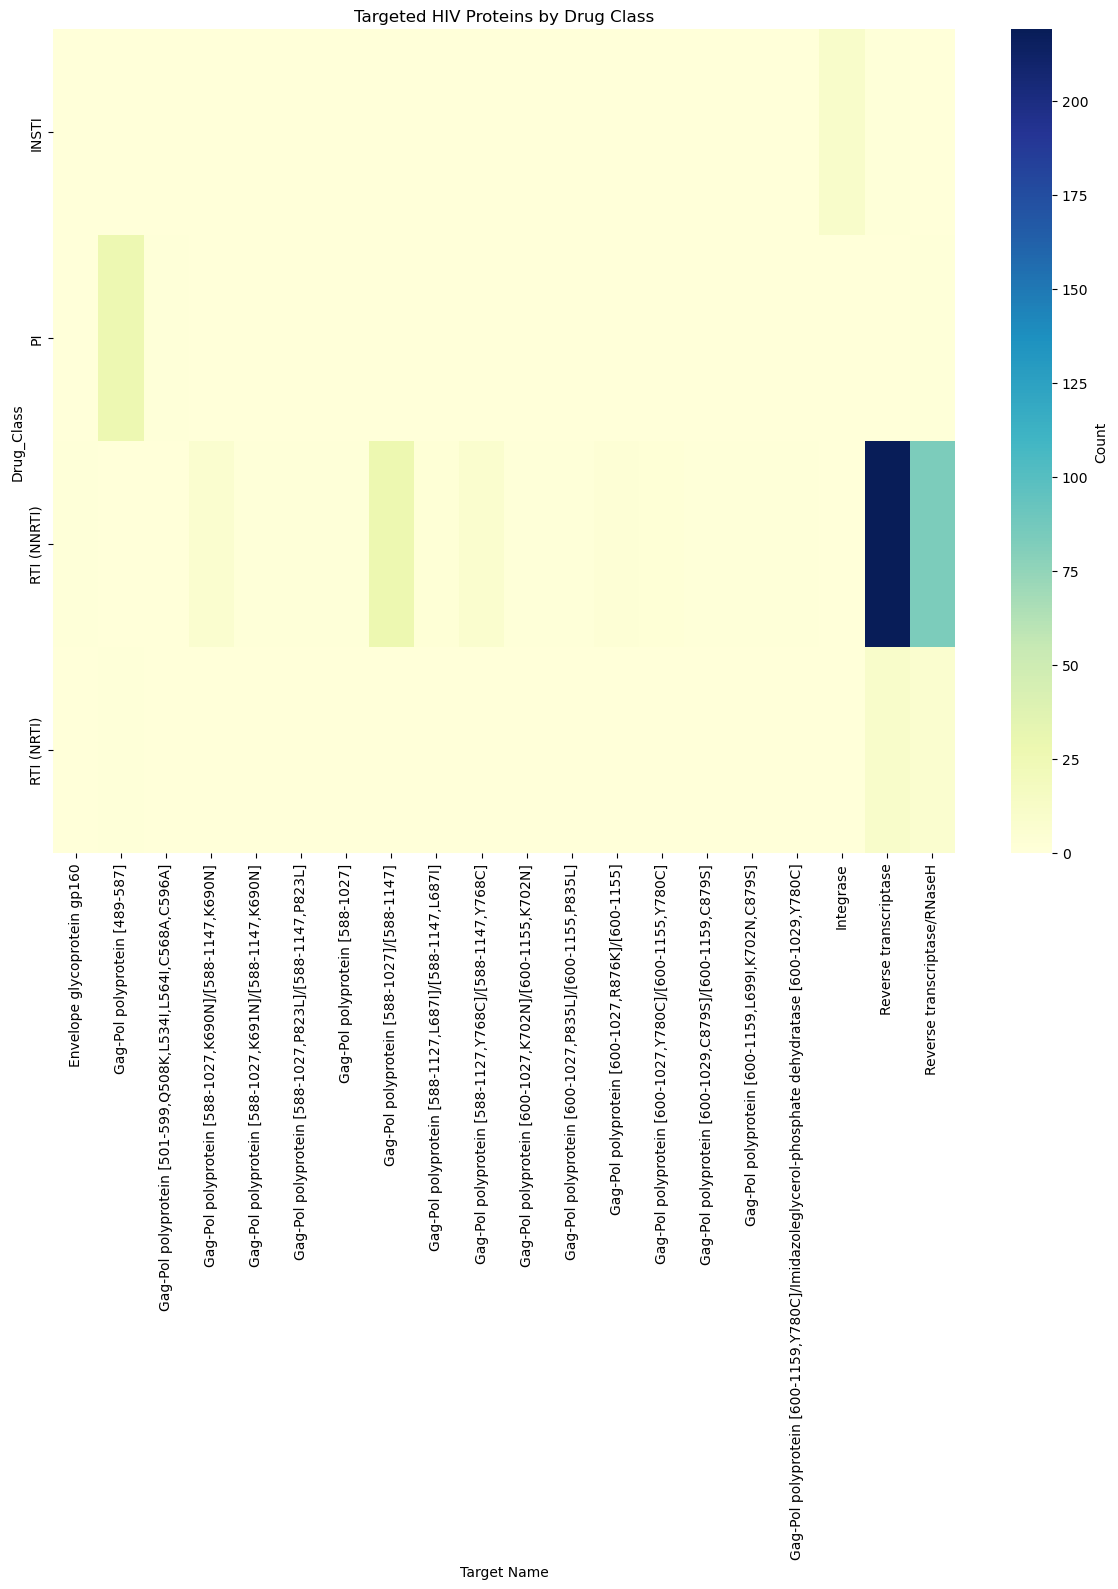

In [15]:
evaluation_utils.plot_protein_target_heatmap(filtered_data, figsize=(12,16))

The plot seems uniform, mostly because Gag-Pol polyprotein is targeted in different locations along its sequence, and mutations are also present. We observe stronger colors for reverse transcriptase, because it is entirely targeted

In [16]:
#some processing for further analyses
filtered_data = pd.merge(filtered_data, doi_df, on='Article DOI', how='outer')
filtered_data = filtered_data.dropna(subset=['IC50 (nM)'])


Let's observe now how the different drug classes have been studied throughout the years.

We utilize the publication year as an approximate indicator to explore temporal trends and patterns of discovery across each drug class. It is important to note that the publication year may not directly align with the actual year of discovery, nor does a higher frequency of publications necessarily reflect greater utilization rates in clinical settings.

Historically, **RTIs** (Reverse Transcriptase Inhibitors) and **NNRTIs** (Non-Nucleoside Reverse Transcriptase Inhibitors) were the first antiretroviral drug classes introduced and are still in use today. **INSTIs** (Integrase Strand Transfer Inhibitors) represent the most recent class of antiretrovirals. Our research indicates that **PIs** (Protease Inhibitors) were introduced after RTIs (doi: 10.1016/j.idc.2014.06.001.)


In [17]:
evaluation_utils.plot_drug_distribution_by_year(filtered_data, year_col='year')

ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

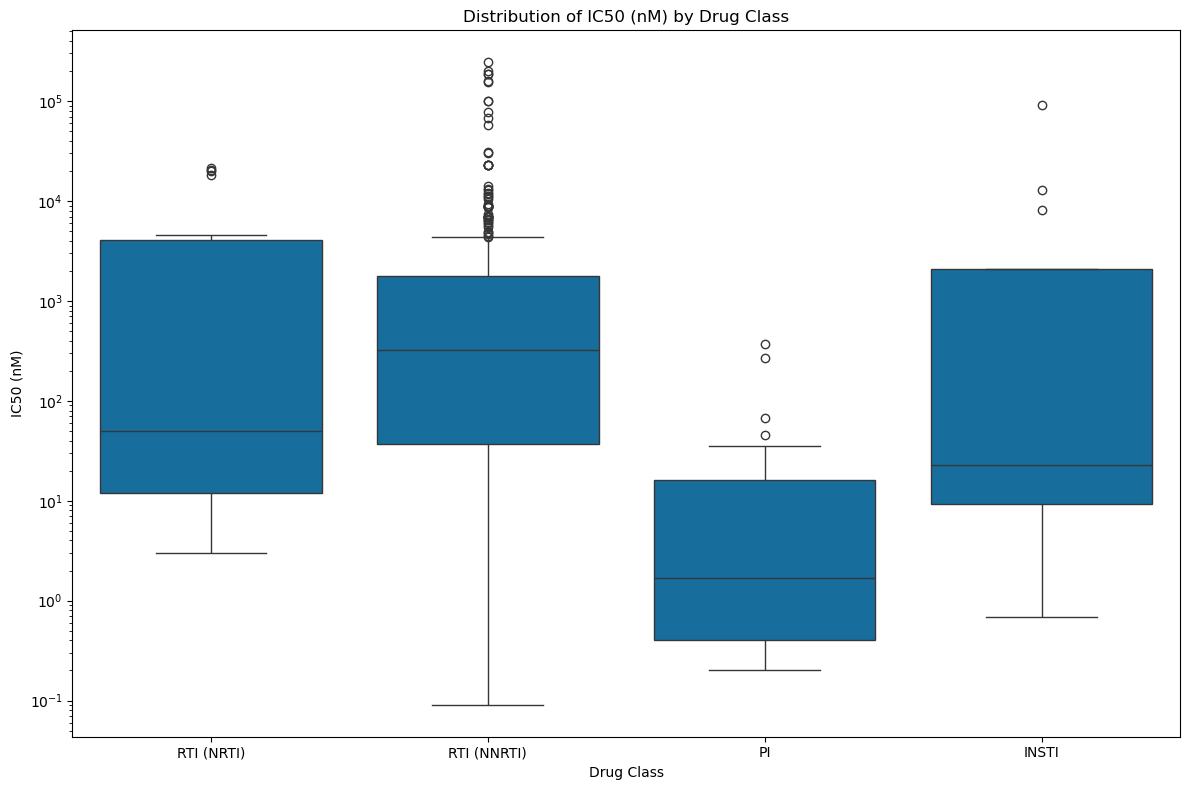

In [18]:
drug_class_order = ['RTI (NRTI)', 'RTI (NNRTI)', 'PI', 'INSTI']

# Assuming `filtered_data` is your processed DataFrame
evaluation_utils.plot_ic50_by_drug_class(filtered_data, drug_class_col='Drug_Class', ic50_col='IC50 (nM)', 
                        drug_class_order=drug_class_order)

In [19]:
rtiNIC50 = filtered_data['IC50 (nM)'][filtered_data['Drug_Class'] == 'RTI (NRTI)']

In [22]:
rtiNNIC50 = filtered_data['IC50 (nM)'][filtered_data['Drug_Class'] == 'RTI (NNRTI)']


In [23]:
PIIC50 = filtered_data['IC50 (nM)'][filtered_data['Drug_Class'] == 'PI']

In [24]:
INSTIIC50 = filtered_data['IC50 (nM)'][filtered_data['Drug_Class'] == 'INSTI']

In [25]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(rtiNIC50, rtiNNIC50)
print('U statistic:', stat)
print('p-value:', p)

U statistic: 3024.0
p-value: 0.38543863568594106


In [26]:
stat, p = mannwhitneyu(rtiNIC50, PIIC50)
print('U statistic:', stat)
print('p-value:', p)

U statistic: 465.0
p-value: 6.672166355526527e-05


In [27]:
stat, p = mannwhitneyu(rtiNIC50, INSTIIC50)
print('U statistic:', stat)
print('p-value:', p)

U statistic: 130.5
p-value: 0.516158372143733


In [28]:
stat, p = mannwhitneyu(PIIC50, rtiNNIC50)
print('U statistic:', stat)
print('p-value:', p)

U statistic: 1147.0
p-value: 2.5954431585379534e-12


In [29]:
stat, p = mannwhitneyu(PIIC50, INSTIIC50)
print('U statistic:', stat)
print('p-value:', p)

U statistic: 80.0
p-value: 0.0073205571401073685


In [30]:
stat, p = mannwhitneyu(rtiNIC50, INSTIIC50)
print('U statistic:', stat)
print('p-value:', p)

U statistic: 130.5
p-value: 0.516158372143733


In [31]:
filtered_data['Drug_Class'].value_counts()

Drug_Class
RTI (NNRTI)    361
PI              29
RTI (NRTI)      19
INSTI           12
Name: count, dtype: int64

### RDKit expansion ###

After this cleaning phase, we can extract other molecular features with the external library 'Rdkit'.

We created the following functions: smiles_to_mol, calculate_descriptors, calculate_morgan_fingerprint.
These functions compute:
- 'smiles_to_mol': creates rdkit mol object from SMILES string
- 'calculate_descriptors': creates a dataframe with 12 features from the molecule
- 'calculate_morgan_fingerprint': extracts the morgan fingerprint for each molecule (with radius 2 and 2048 entries)ies)

Before doing this, we perform additional cleaning, removing unuseful columns and rows.

In [57]:
hiv_condensed['Target Name']

177               Gag-Pol polyprotein
178               Gag-Pol polyprotein
179               Gag-Pol polyprotein
180               Gag-Pol polyprotein
181               Gag-Pol polyprotein
                     ...             
30145    Reverse transcriptase/RNaseH
30146    Reverse transcriptase/RNaseH
30147             Gag-Pol polyprotein
30148             Gag-Pol polyprotein
30149             Gag-Pol polyprotein
Name: Target Name, Length: 13754, dtype: object

In [262]:
#hivRD = hiv_condensed[hiv_condensed['Target Name'] == 'Gag-Pol polyprotein'].copy()
hivRD = hiv.copy()


In [263]:
hivRD = data_utils.nan_to_numeric(hivRD)


In [60]:
hivRD.columns

Index(['index', 'BindingDB Reactant_set_id', 'Ligand SMILES',
       'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'IC50 (nM)', 'Curation/DataSource', 'BindingDB Entry DOI',
       'Link to Ligand in BindingDB', 'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequence'],
      dtype='object')

In [23]:
hiv.columns

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'IC50 (nM)', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'Authors', 'Institution',
       'Link to Ligand in BindingDB', 'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'PubChem CID', 'PubChem SID',
       'ZINC ID of Ligand',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain',
       'UniProt (TrEMBL) Submitted Name of Target Chain',
       'UniProt (TrEMBL) Entry Name of Target Chain',
       'UniProt (TrEMBL) Primary ID of Target Chain'],
      dtype='object')

With the data ready, we can use the first function to get the 'mol' rdkit object from the molecule SMILES. This object will be used later to compute all features and the morgan fingerprints.

In [153]:
# Convert SMILES to RDKit Mol objects
hivRD['Mol'] = hivRD['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)

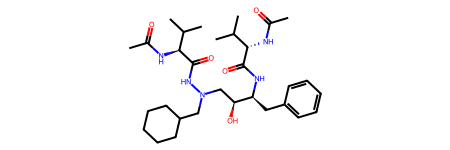

In [101]:
#try to print the first one, for seek of visualization
hivRD['Mol'][0]

Now we can compute all molecular descriptors starting from the 'Mol' column. The chosen descriptors are:
- **MolWt**: The molecular weight of the molecule, calculated as the sum of the atomic weights of all atoms present.
- **LogP**: The octanol-water partition coefficient (Log P), indicating the molecule's lipophilicity or hydrophobicity.
- **NumHDonors**: Number of hydrogen bond donors, typically counting hydrogen atoms attached to oxygen or nitrogen.
- **NumHAcceptors**: Number of hydrogen bond acceptors, such as oxygen or nitrogen atoms with lone pairs.
- **TPSA**: Topological Polar Surface Area, representing the surface area occupied by polar atoms; useful for predicting drug absorption.
- **NumRotatableBonds**: Number of rotatable bonds, affecting the molecule's flexibility.
- **NumAromaticRings**: Number of aromatic rings within the molecule.
- **NumAliphaticRings**: Number of aliphatic (non-aromatic) rings in the molecule.
- **FractionCSP3**: Fraction of sp³-hybridized carbons over total carbons, indicating the molecule's saturation level.
- **RingCount**: Total number of rings, both aromatic and aliphatic, present in the molecule.
- **FormalCharge**: The net formal charge of the molecule, calculated based on its electron configuration.
- **NumRadicalElectrons**: Number of unpaired (radical) electrons in the molecule.

In [98]:
hivRD.columns

Index(['index', 'BindingDB Reactant_set_id', 'Ligand SMILES',
       'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'IC50 (nM)', 'Curation/DataSource', 'BindingDB Entry DOI',
       'Link to Ligand in BindingDB', 'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'Mol'],
      dtype='object')

In [39]:
from rdkit import Chem
from rdkit.Chem import Draw
# MOLECULAR WEIGTH AND AFFINIT
logf = hivRD['TPSA'].apply(np.log)
icl = hivRD['IC50 (nM)'].apply(np.log)
# PLOT
plt.figure(figsize=(8, 6))
plt.scatter(hivRD['NumRadicalElectrons'], hivRD['IC50 (nM)'],s = 3)
plt.xlabel('Molecular Weight')
plt.ylabel('IC50 (nM)')
plt.title('Molecular Weight vs. IC50 for Ligands')
plt.show()


KeyError: 'TPSA'

In [154]:
# Calculate descriptors and add them to the DataFrame
descriptor_df = hivRD['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD = pd.concat([hivRD, descriptor_df], axis=1)

In [45]:
numerical_df.columns

Index(['index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID',
       'IC50 (nM)',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA',
       'NumRotatableBonds', 'NumAromaticRings', 'NumAliphaticRings',
       'FractionCSP3', 'RingCount', 'FormalCharge', 'BalabanJ', 'BertzCT',
       'MolMR', 'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters',
       'NumSpiroAtoms', 'NumBridgeheadAtoms', 'Chi0n', 'Chi0v', 'Chi1n',
       'Chi1v', 'NumSaturatedRings', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles'],
      dtype='object')

Now compute the morgan fingerprint for each molecule. The **Morgan fingerprint** is a type of molecular fingerprint that represents molecules based on their structural and topological features. It is generated by iteratively expanding each atom's neighborhood up to a specified radius, creating a unique identifier for each substructure. This identifier can then be hashed to a fixed-length bit vector, making it suitable for various similarity comparisons and machine learning applications.

The used rdkit parameters to generate them are:

- **Radius**: Controls the neighborhood size around each atom to include in the fingerprint. A common choice is `radius=2` (as chosen here), which captures the atom's environment up to two bonds away, balancing structural detail with compactness.
- **Bits**: Determines the length of the bit vector, usually specified in powers of 2 (e.g., 1024 or 2048 bits, as in this case). Higher bit counts reduce hash collisions but increase memory usage.

Morgan fingerprints can be especially useful alongside the previously generated molecular descriptors as they provide a comprehensive structural encoding. By representing a molecule's topology, Morgan fingerprints capture substructural similarities between molecules, which can be particularly valuable in tasks like drug discovery, where finding structurally similar molecules often correlates with similar biological activity.

In [155]:
# Calculate fingerprints and add them to the DataFrame
fingerprint_df = hivRD['Mol'].apply(lambda mol: rdkit_extraction.calculate_morgan_fingerprint(mol))
hivRD= pd.concat([hivRD, fingerprint_df], axis=1)

Now try to see how the descriptors and fingerprint look like, to get a glimpse of what's inside. `descriptor_df` contains the expanded molecular features, while `fingerprint_df` contains the morgan fingerprints, that are in fact saved as bitvectors

In [28]:
descriptor_df.head()

,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,...,NumUnspecifiedAtomStereoCenters,NumSpiroAtoms,NumBridgeheadAtoms,Chi0n,Chi0v,Chi1n,Chi1v,NumSaturatedRings,NumSaturatedCarbocycles,NumSaturatedHeterocycles
0,573.779,2.3097,5.0,6.0,139.87,15.0,1.0,1.0,0.677419,2.0,...,0.0,0.0,0.0,25.612478,25.612478,14.989013,14.989013,1.0,1.0,0.0
1,633.831,3.5297,5.0,8.0,158.33,17.0,1.0,1.0,0.696970,2.0,...,0.0,0.0,0.0,27.843188,27.843188,16.388825,16.388825,1.0,1.0,0.0
2,693.883,2.7827,5.0,10.0,176.79,21.0,1.0,1.0,0.714286,2.0,...,0.0,0.0,0.0,30.073898,30.073898,17.368458,17.368458,1.0,1.0,0.0
3,781.989,2.8159,5.0,12.0,195.25,27.0,1.0,1.0,0.743590,2.0,...,0.0,0.0,0.0,33.718822,33.718822,19.523159,19.523159,1.0,1.0,0.0
4,717.868,2.5911,6.0,9.0,205.08,17.0,3.0,1.0,0.473684,4.0,...,0.0,0.0,0.0,30.047396,30.047396,17.803200,17.803200,1.0,1.0,0.0


In [29]:
fingerprint_df.head()

0    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
3    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
4    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Mol, dtype: object

Now we can plot the correlation matrix of the numerical dataframe, to see some of the rdkit features are somehow correlated with IC50, or between them. To do this and further numerical analysis, we separate the numerical columns of the dataframe, creating a  `numerical_df` (which will be normalize to get all features in the same range), and the non numerical ones (including Morgan Fingerprints), in a `non_numerical_df`.

In [156]:
numerical_df, non_numerical_df = data_utils.separe_num_df(hivRD)
numerical_df = (numerical_df - numerical_df.min())/(numerical_df.max() - numerical_df.min())
numerical_df = numerical_df.drop(columns=['NumRadicalElectrons']) #column dropped as it was all 0-valued

In [104]:
corr1 = numerical_df.corr()
corr1.style.background_gradient(cmap='coolwarm')

,index,BindingDB Reactant_set_id,BindingDB MonomerID,IC50 (nM),Number of Protein Chains in Target (>1 implies a multichain complex),MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,FormalCharge
index,1.000000,0.835198,0.664504,0.046418,-0.586478,-0.020821,-0.038268,-0.001477,0.083867,0.048646,-0.028124,0.081438,-0.112546,-0.146154,-0.009646,0.001653
BindingDB Reactant_set_id,0.835198,1.000000,0.805742,0.042839,-0.675903,0.043416,-0.134370,0.113251,0.165865,0.144221,0.051956,0.066459,-0.084358,-0.123235,-0.003015,-0.032390
BindingDB MonomerID,0.664504,0.805742,1.000000,-0.009987,-0.546274,0.101950,-0.106433,0.139959,0.229100,0.186627,0.112749,0.125136,-0.115581,-0.106915,0.022386,-0.041575
IC50 (nM),0.046418,0.042839,-0.009987,1.000000,-0.028515,-0.037988,-0.034637,-0.014164,-0.031680,-0.013304,-0.024761,-0.032354,-0.036154,-0.061643,-0.048629,-0.010807
Number of Protein Chains in Target (>1 implies a multichain complex),-0.586478,-0.675903,-0.546274,-0.028515,1.000000,-0.173040,0.016909,-0.165639,-0.219695,-0.188905,-0.153409,-0.096336,-0.028169,-0.055795,-0.093234,0.021033
MolWt,-0.020821,0.043416,0.101950,-0.037988,-0.173040,1.000000,-0.009607,0.836867,0.813082,0.888415,0.920789,0.450098,0.274136,0.392346,0.528069,-0.013595
LogP,-0.038268,-0.134370,-0.106433,-0.034637,0.016909,-0.009607,1.000000,-0.359194,-0.310026,-0.357975,-0.145649,0.348190,0.121134,-0.046936,0.349514,0.124818
NumHDonors,-0.001477,0.113251,0.139959,-0.014164,-0.165639,0.836867,-0.359194,1.000000,0.744638,0.924585,0.858608,0.286081,0.093083,0.257050,0.282989,0.028341
NumHAcceptors,0.083867,0.165865,0.229100,-0.031680,-0.219695,0.813082,-0.310026,0.744638,1.000000,0.899647,0.776815,0.316418,0.138455,0.274518,0.336029,-0.141394
TPSA,0.048646,0.144221,0.186627,-0.013304,-0.188905,0.888415,-0.357975,0.924585,0.899647,1.000000,0.887281,0.316662,0.098672,0.253472,0.310409,-0.086834


 We can see that IC50 is not particularly correlated with other features, but there are other features which are correlated between them. To exploit this effect, interaction terms between highly correlated variables (as and ) were added and IC50 transformations were tested (to not include too many things, these matrices are shown in [`./tests/rdkit_analysis.ipynb`](./tests/rdkit_analysis.ipynb)), but none of them led to higher correlations between affinity and other features. Another possibility was to recompute correlation just on high affinity drugs, to see if they somehow differ from other ones.

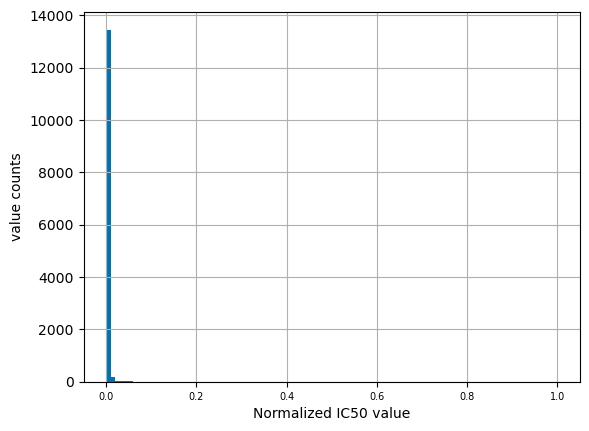

In [118]:
numerical_df['IC50 (nM)'].hist(bins=100)
plt.xticks(fontsize=7)
plt.xlabel('Normalized IC50 value')
plt.ylabel('value counts')
plt.show()

A threshold of 0.00017 to define a high affinity drug was set based on the IC50 distribution. Still, almost nothing changed in terms of correlation.

In [157]:
#Now we can filter the data including only high affinity ligands with the above mentioned threshold
df_low_IC50 = numerical_df[numerical_df['IC50 (nM)'] < 1e20]
corrlic =df_low_IC50.corr()
corrlic.style.background_gradient(cmap='coolwarm')

,index,BindingDB Reactant_set_id,BindingDB MonomerID,IC50 (nM),Number of Protein Chains in Target (>1 implies a multichain complex),MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,FormalCharge,BalabanJ,BertzCT,MolMR,NumAtomStereoCenters,NumUnspecifiedAtomStereoCenters,NumSpiroAtoms,NumBridgeheadAtoms,Chi0n,Chi0v,Chi1n,Chi1v,NumSaturatedRings,NumSaturatedCarbocycles,NumSaturatedHeterocycles
index,1.000000,0.912988,0.795378,0.033767,-0.556093,0.405382,-0.006404,0.362740,0.348015,0.406280,0.390168,0.093143,0.064979,0.282414,0.126043,-0.018893,-0.185705,0.361372,0.400122,0.375239,0.095637,0.064969,0.076781,0.411593,0.407054,0.408935,0.411461,0.106545,0.017478,0.123676
BindingDB Reactant_set_id,0.912988,1.000000,0.879616,0.044431,-0.621984,0.478255,0.015439,0.443866,0.388375,0.456624,0.447507,0.089580,0.137536,0.358271,0.184041,-0.031325,-0.240725,0.411008,0.484675,0.483893,0.153411,0.091425,0.122507,0.496602,0.489183,0.496441,0.488007,0.139254,0.010060,0.170520
BindingDB MonomerID,0.795378,0.879616,1.000000,0.058069,-0.550902,0.440794,-0.001033,0.418989,0.368662,0.434628,0.435900,0.089864,0.107628,0.308973,0.159222,-0.035455,-0.203250,0.378283,0.445880,0.427830,0.150733,0.105529,0.134192,0.456902,0.448430,0.457373,0.444568,0.085348,0.007109,0.103856
IC50 (nM),0.033767,0.044431,0.058069,1.000000,-0.019920,-0.008582,-0.025359,0.016294,-0.018869,0.014916,0.018239,-0.033593,-0.015617,-0.006111,-0.038914,-0.004123,0.037539,-0.016569,-0.012381,-0.011355,0.071966,0.047555,0.042747,-0.009345,-0.012149,-0.009230,-0.015112,-0.014247,-0.005193,-0.014556
Number of Protein Chains in Target (>1 implies a multichain complex),-0.556093,-0.621984,-0.550902,-0.019920,1.000000,-0.641861,-0.073660,-0.549963,-0.558186,-0.565684,-0.588049,-0.179440,-0.200376,-0.503792,-0.305767,0.016504,0.422154,-0.544723,-0.650206,-0.688125,-0.227653,-0.066307,-0.078296,-0.665522,-0.655937,-0.668976,-0.665144,-0.296097,-0.007863,-0.371967
MolWt,0.405382,0.478255,0.440794,-0.008582,-0.641861,1.000000,0.095783,0.804062,0.836605,0.885558,0.886111,0.310272,0.254704,0.549031,0.451886,-0.001235,-0.518198,0.901241,0.985782,0.796298,0.099241,-0.016850,0.173111,0.981351,0.991885,0.973048,0.981874,0.298375,0.026622,0.361848
LogP,-0.006404,0.015439,-0.001033,-0.025359,-0.073660,0.095783,1.000000,-0.262056,-0.123868,-0.222067,-0.008522,0.350720,-0.012091,-0.079351,0.259665,0.020209,-0.203104,0.200856,0.123039,-0.121447,0.278238,0.025663,0.140233,0.089481,0.107645,0.096956,0.110498,-0.033125,0.121045,-0.126257
NumHDonors,0.362740,0.443866,0.418989,0.016294,-0.549963,0.804062,-0.262056,1.000000,0.638081,0.873591,0.813864,0.159736,0.101354,0.482812,0.207718,0.078307,-0.375545,0.661996,0.809195,0.784981,-0.035728,-0.035190,0.087321,0.813746,0.800965,0.811043,0.776301,0.172341,0.011495,0.211698
NumHAcceptors,0.348015,0.388375,0.368662,-0.018869,-0.558186,0.836605,-0.123868,0.638081,1.000000,0.862266,0.750774,0.256900,0.231132,0.463127,0.391098,-0.083103,-0.405223,0.781299,0.806560,0.614492,0.064493,0.000424,0.161087,0.816128,0.826015,0.794330,0.819669,0.261745,-0.062042,0.376711
TPSA,0.406280,0.456624,0.434628,0.014916,-0.565684,0.885558,-0.222067,0.873591,0.862266,1.000000,0.866784,0.215286,0.115268,0.459979,0.262097,-0.041338,-0.330609,0.807972,0.863662,0.719587,0.010930,0.006718,0.146188,0.875639,0.872032,0.858838,0.853666,0.159922,-0.023413,0.220103


## Tanimoto Similarity with Morgan Fingerprints ##

 
The previous findings convinced us to make further analysis, suggesting that maybe these molecular features aren't enough to fully capture ligands charateristics. For this reason, successive ones are conducted on Morgan Fingerprints similarities, which potentially convey more informations. As there are more or less 9000 molecules, compute the similarity between each pair is not feasible. For this reason, similarity is more likely to be computed from each couple of a sample of size s out of these 9000. But what value should be given to s? The answer can be given considering a trade-off between statistical significance (not too low s) and computational resources (not too high). Considering that for a population of size N an ideal value starts from $\sqrt{N}$, the lower bound for s is around 94. The upper bound can be obtained by experimenting different values.After some experiments, a sample size of 5000 is taken.

These 5000 samples will be extracted without replacement from the initial dataset (filtered by low IC50 values)

In [ ]:
df_

In [107]:
df_sample = data_utils.create_df_mf(non_numerical_df, df_low_IC50)

Now that we have morgan fingerprints for high affinity ligands, we can see if they are somehow similar, trying different methods.
The first step is to compute Tanimoto similarity between each pair of ligands, and store them in a similarity matrix (in this case of size 5000 x 5000). This score is used because it's accurate to compare each bit of each fingerprint, to catch possible structural similarities.

In [56]:
similarities, similarity_matrix =  rdkit_extraction.compute_tanimoto_similarities(df_sample)

To get a first glimpse of the data, we can visualize this matrix with a heatpamp, to see if there are some evident patterns

<Axes: >

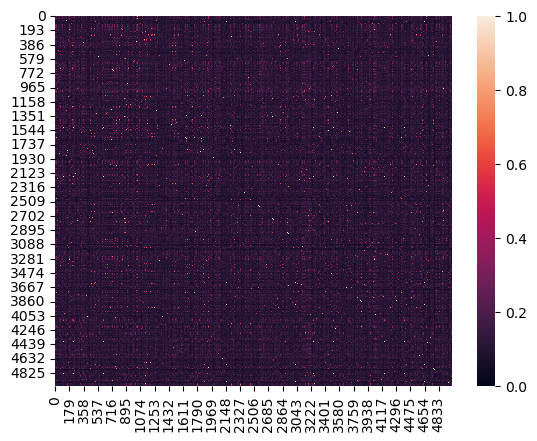

In [57]:
#Now we can try to plot the similarity matrix with a heatmap, to see if there are some evident similarities
sns.heatmap(similarity_matrix)

Some samples look similar (there are few bright spots), but the majority of the couples have similarity lower than 0.3, indicating that we should use other methods to understand how such ligands are similar.

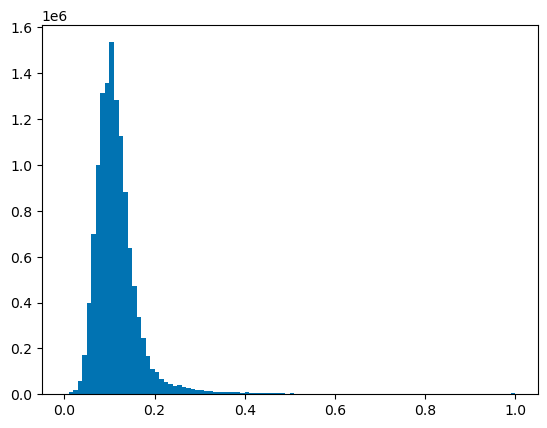

In [58]:
plt.hist(similarities, bins=100)
plt.show()

The distribution confirms that the majority of the similarity values lie below 0.3. This can be further verified with some summary statistics.

In [59]:
avg_similarity = np.mean(similarities)
min_similarity = np.min(similarities)
max_similarity = np.max(similarities)

print(f'Average similarity: {avg_similarity}')
print(f'Min similarity: {min_similarity}')
print(f'Max similarity: {max_similarity}')

Average similarity: 0.1190282743943658
Min similarity: 0.0
Max similarity: 1.0


## Clustering ##

This and other findings (present in the file ''), convinced us to exploit other methods to see if there are similarities between high affinity compounds. Specifically, using clustering can identify more deep patterns between molecules. This approach can be potentially applied to:

- **Molecular features**: Rdkit features extracted from SMILES strings;
- **Morgan Fingerprints**;
- **Similarity matrix** between morgan fingerprints.

**Molecular features** are suitable for K-means, as the number of features is not too high, so that euclidean distance is meaningful to discriminate between them. With the same argument, K-means won't be used on **Morgan Fingerprints**, as 2048 features are too many, leading to a possible curse of dimensionality (also, it's not too meaningful as they are bitvectors). However, using **Similarity matrix** instead of fingerprints can bring meaningful insights. Specifically, spectral clustering can be run on such matrix. With these two approaches, we will be possibly be able to group ligands based on more general molecular features as well as more 'complex' structural patterns.

### K-means on molecular features ###

First, we can run K-means on the original df_low_IC50 dataframe (as now using all 9000 features is computationally feasible). Then, clustering results can be visualized along the first two or three principal components, to see how their shape describes them. To decide the number of clusters we can use the elbow method. (other clustering approaches were tried in [`./tests/rdkit_analysis.ipynb`](./tests/rdkit_analysis.ipynb)).


In [238]:
df_low_IC50_pd = df_low_IC50.drop(columns=['index', 'BindingDB Reactant_set_id',	'BindingDB MonomerID',	'IC50 (nM)', 'Number of Protein Chains in Target (>1 implies a multichain complex)'])

In [236]:
hivRD['Number of Protein Chains in Target (>1 implies a multichain complex)'].value_counts()

Number of Protein Chains in Target (>1 implies a multichain complex)
1.0    3256
2.0    1945
Name: count, dtype: int64

In [239]:
df_low_IC50_pd

,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,...,NumUnspecifiedAtomStereoCenters,NumSpiroAtoms,NumBridgeheadAtoms,Chi0n,Chi0v,Chi1n,Chi1v,NumSaturatedRings,NumSaturatedCarbocycles,NumSaturatedHeterocycles
0,0.274423,0.275993,0.277778,0.277778,0.250546,0.267857,0.090909,0.055556,0.724138,0.095238,...,0.000000,0.0,0.0,0.314726,0.306201,0.312839,0.305758,0.0625,0.0625,0.00
1,0.316231,0.337607,0.277778,0.388889,0.284397,0.303571,0.090909,0.055556,0.745037,0.095238,...,0.000000,0.0,0.0,0.350985,0.342911,0.350610,0.343919,0.0625,0.0625,0.00
2,0.358039,0.299881,0.277778,0.500000,0.318248,0.375000,0.090909,0.055556,0.763547,0.095238,...,0.000000,0.0,0.0,0.387244,0.379621,0.377044,0.370625,0.0625,0.0625,0.00
3,0.419378,0.301558,0.277778,0.611111,0.352099,0.482143,0.090909,0.055556,0.794872,0.095238,...,0.000000,0.0,0.0,0.446490,0.439604,0.435185,0.429365,0.0625,0.0625,0.00
4,0.374737,0.290205,0.333333,0.444444,0.370125,0.303571,0.272727,0.055556,0.506352,0.190476,...,0.000000,0.0,0.0,0.386813,0.379185,0.388775,0.382477,0.0625,0.0625,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5196,0.063099,0.289483,0.166667,0.222222,0.160747,0.017857,0.272727,0.000000,0.000000,0.142857,...,0.000000,0.0,0.0,0.064199,0.052558,0.066039,0.056416,0.0000,0.0000,0.00
5197,0.171117,0.326360,0.055556,0.388889,0.245191,0.125000,0.272727,0.000000,0.242947,0.142857,...,0.333333,0.0,0.0,0.170392,0.160072,0.162559,0.153930,0.0000,0.0000,0.00
5198,0.237433,0.302230,0.111111,0.333333,0.203840,0.214286,0.181818,0.055556,0.534483,0.142857,...,0.000000,0.0,0.0,0.239759,0.243738,0.234828,0.266201,0.0625,0.0000,0.25
5199,0.227668,0.275256,0.166667,0.277778,0.238388,0.250000,0.181818,0.000000,0.470345,0.095238,...,0.000000,0.0,0.0,0.227642,0.231470,0.215971,0.247150,0.0000,0.0000,0.00


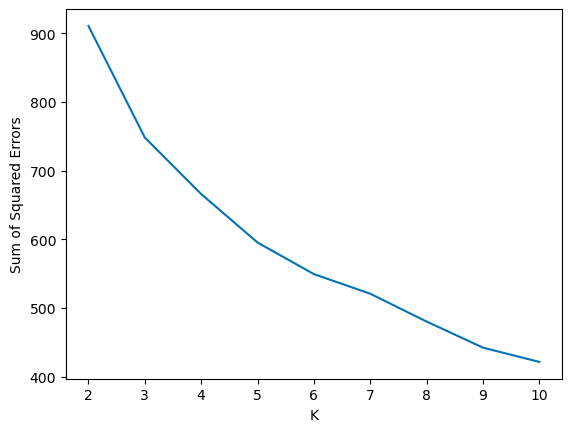

In [240]:
from sklearn.cluster import KMeans,SpectralClustering
#plot SSE against K to look for the elbow
evaluation_utils.plot_sse(df_low_IC50_pd)

The optimal value is clearly 4.

In [134]:
k = 4 # Number of clusters, chosen based on above elbow method
km = KMeans(n_clusters=k, random_state=42)
clusters_km = km.fit_predict(df_low_IC50_pd)
df_low_IC50['km_Cluster'] = clusters_km
print(df_low_IC50.groupby('km_Cluster').size())  # Check the size of each cluster
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning) #ignore warning

km_Cluster
0    1968
1    2031
2      87
3    1115
dtype: int64


In [267]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(df_low_IC50_pd)

dbscan = DBSCAN(eps=0.6, min_samples=5)
clusters = dbscan.fit_predict(df_low_IC50_pd)

In [268]:
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4])

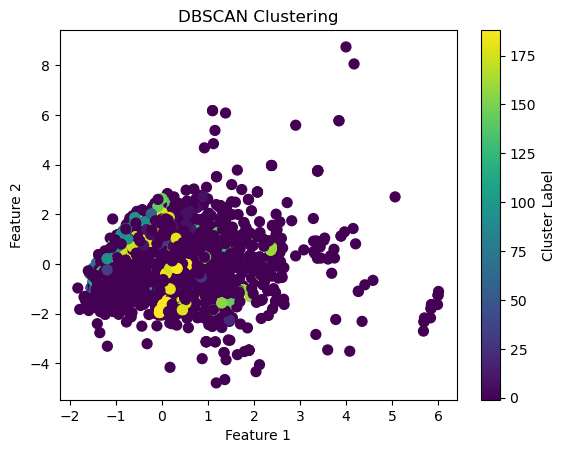

In [138]:
#df['cluster'] = clusters

# Step 4: Visualize the results (optional)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster Label')
plt.show()

In [231]:
df_low_IC50_pd.columns

Index(['Number of Protein Chains in Target (>1 implies a multichain complex)',
       'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA',
       'NumRotatableBonds', 'NumAromaticRings', 'NumAliphaticRings',
       'FractionCSP3', 'RingCount', 'FormalCharge', 'BalabanJ', 'BertzCT',
       'MolMR', 'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters',
       'NumSpiroAtoms', 'NumBridgeheadAtoms', 'Chi0n', 'Chi0v', 'Chi1n',
       'Chi1v', 'NumSaturatedRings', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles'],
      dtype='object')

In [162]:
df_low_IC50_clustering = df_low_IC50.drop(columns=['km_Cluster'])

KeyError: "['km_Cluster'] not found in axis"

The cluster numerical size is not too unbalanced, suggesting a meaningful capturing of underlyng similarities between ligands. At last, we can visualize 2D and 3D PCA.

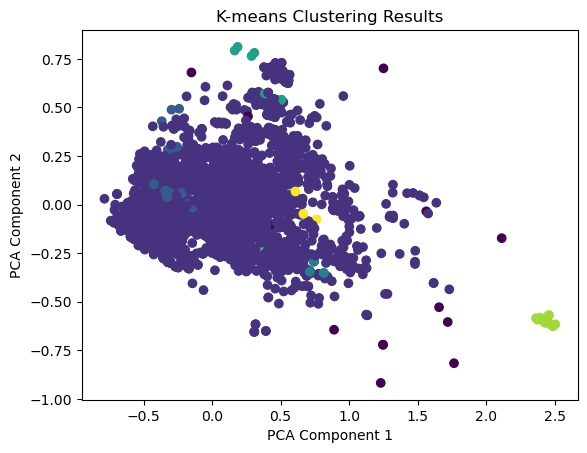

In [255]:
evaluation_utils.plot_pca_2d(df_low_IC50_pd, clusters, kmc=True)

In [68]:
df_low_IC50['IC50 (nM)']

0        4.465887e-07
1        9.309980e-06
2        8.626157e-06
3        3.523790e-06
4        1.419721e-06
             ...     
13749    1.052034e-03
13750    6.890774e-05
13751    2.204012e-07
13752    6.306947e-07
13753    5.149709e-07
Name: IC50 (nM), Length: 13754, dtype: float64

In [37]:
len(np.unique(reduced_data[:,0]))

NameError: name 'reduced_data' is not defined

In [47]:
df_low_IC50.columns

Index(['index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID',
       'IC50 (nM)',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA',
       'NumRotatableBonds', 'NumAromaticRings', 'NumAliphaticRings',
       'FractionCSP3', 'RingCount', 'FormalCharge', 'BalabanJ', 'BertzCT',
       'MolMR', 'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters',
       'NumSpiroAtoms', 'NumBridgeheadAtoms', 'Chi0n', 'Chi0v', 'Chi1n',
       'Chi1v', 'NumSaturatedRings', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles', 'km_Cluster'],
      dtype='object')

In [164]:
df_low_IC50_pd

,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,...,NumUnspecifiedAtomStereoCenters,NumSpiroAtoms,NumBridgeheadAtoms,Chi0n,Chi0v,Chi1n,Chi1v,NumSaturatedRings,NumSaturatedCarbocycles,NumSaturatedHeterocycles
0,0.274423,0.275993,0.277778,0.277778,0.250546,0.267857,0.090909,0.055556,0.724138,0.095238,...,0.000000,0.0,0.0,0.314726,0.306201,0.312839,0.305758,0.0625,0.0625,0.00
1,0.316231,0.337607,0.277778,0.388889,0.284397,0.303571,0.090909,0.055556,0.745037,0.095238,...,0.000000,0.0,0.0,0.350985,0.342911,0.350610,0.343919,0.0625,0.0625,0.00
2,0.358039,0.299881,0.277778,0.500000,0.318248,0.375000,0.090909,0.055556,0.763547,0.095238,...,0.000000,0.0,0.0,0.387244,0.379621,0.377044,0.370625,0.0625,0.0625,0.00
3,0.419378,0.301558,0.277778,0.611111,0.352099,0.482143,0.090909,0.055556,0.794872,0.095238,...,0.000000,0.0,0.0,0.446490,0.439604,0.435185,0.429365,0.0625,0.0625,0.00
4,0.374737,0.290205,0.333333,0.444444,0.370125,0.303571,0.272727,0.055556,0.506352,0.190476,...,0.000000,0.0,0.0,0.386813,0.379185,0.388775,0.382477,0.0625,0.0625,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5196,0.063099,0.289483,0.166667,0.222222,0.160747,0.017857,0.272727,0.000000,0.000000,0.142857,...,0.000000,0.0,0.0,0.064199,0.052558,0.066039,0.056416,0.0000,0.0000,0.00
5197,0.171117,0.326360,0.055556,0.388889,0.245191,0.125000,0.272727,0.000000,0.242947,0.142857,...,0.333333,0.0,0.0,0.170392,0.160072,0.162559,0.153930,0.0000,0.0000,0.00
5198,0.237433,0.302230,0.111111,0.333333,0.203840,0.214286,0.181818,0.055556,0.534483,0.142857,...,0.000000,0.0,0.0,0.239759,0.243738,0.234828,0.266201,0.0625,0.0000,0.25
5199,0.227668,0.275256,0.166667,0.277778,0.238388,0.250000,0.181818,0.000000,0.470345,0.095238,...,0.000000,0.0,0.0,0.227642,0.231470,0.215971,0.247150,0.0000,0.0000,0.00


In [244]:
from sklearn.decomposition import PCA
#dfpc = df_low_IC50.drop(columns=['index', 'km_Cluster', 'IC50 (nM)', 'BindingDB Reactant_set_id',	'BindingDB MonomerID'])
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(df_low_IC50_pd)
#icl = df_low_IC50['IC50 (nM)'].apply(np.log)
#plt.scatter(reduced_data[:, 0], reduced_data[:,1], s=1, cmap=km)
#plt.xlabel("PCA Component 1")
#plt.ylabel("iC50")
#plt.show()

In [214]:
reduced_data.shape

(5201, 6)

In [215]:
components = pca.components_

In [216]:
feature_names = df_low_IC50_pd.columns
loadings_df = pd.DataFrame(components, columns=feature_names, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

In [217]:
loadings_df.T

,PC1,PC2,PC3,PC4,PC5,PC6
MolWt,0.284680,-0.116560,-0.047710,0.011439,0.002111,0.077822
LogP,0.000374,-0.057742,-0.259122,0.257113,-0.390747,0.272133
NumHDonors,0.234359,-0.130218,0.259118,-0.078210,0.046860,-0.320221
NumHAcceptors,0.258688,-0.091846,-0.064114,-0.130532,0.571057,0.204673
TPSA,0.214306,-0.148042,0.131041,-0.056017,0.313406,-0.035380
NumRotatableBonds,0.227376,-0.157307,0.152501,0.072312,0.047687,-0.046983
NumAromaticRings,0.039197,-0.283538,-0.358370,-0.095526,-0.138915,-0.029758
NumAliphaticRings,0.046560,0.165373,-0.115040,-0.033005,-0.066702,0.058459
FractionCSP3,0.272328,0.484734,0.419232,0.190347,-0.221834,0.343345
RingCount,0.060440,-0.006772,-0.286324,-0.078327,-0.129939,0.034521


In [246]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df_low_IC50_pd)  # Ensure data is scaled

In [247]:
X_tsne.shape

(5201, 2)

(5201,)

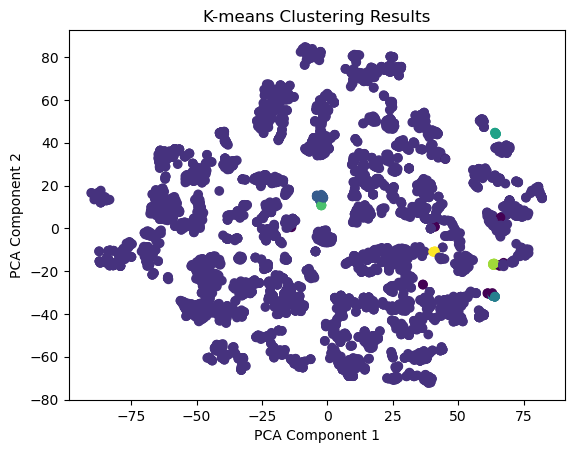

In [258]:
#clusters = df_low_IC50['km_Cluster']

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters)
plt.title("K-means Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [132]:
df_low_IC50['IC50 (nM)']

0        4.465887e-07
1        9.309980e-06
2        8.626157e-06
3        3.523790e-06
4        1.419721e-06
             ...     
13749    1.052034e-03
13750    6.890774e-05
13751    2.204012e-07
13752    6.306947e-07
13753    5.149709e-07
Name: IC50 (nM), Length: 13754, dtype: float64

In [266]:
df_low_IC50_bxp = df_low_IC50.drop(columns=['index',	'BindingDB Reactant_set_id',	'BindingDB MonomerID',	'Number of Protein Chains in Target (>1 implies a multichain complex)'])

In [269]:
df_low_IC50_bxp['Clusters'] = clusters

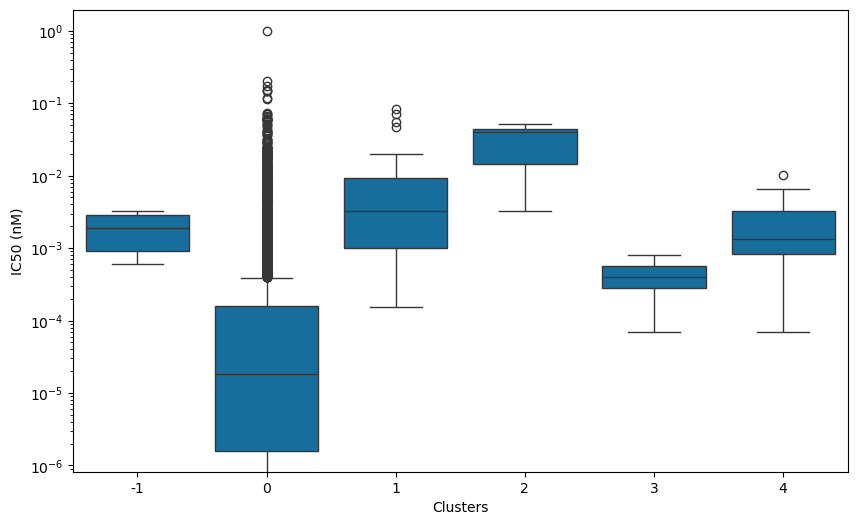

In [271]:
plt.figure(figsize=(10, 6))
sns.boxplot(x ='Clusters', y='IC50 (nM)', data =df_low_IC50_bxp)
plt.yscale('log')

In [273]:
dfgrp = df_low_IC50_bxp.groupby(['Clusters']).mean()
dfgrp

,IC50 (nM),MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,...,NumUnspecifiedAtomStereoCenters,NumSpiroAtoms,NumBridgeheadAtoms,Chi0n,Chi0v,Chi1n,Chi1v,NumSaturatedRings,NumSaturatedCarbocycles,NumSaturatedHeterocycles
Clusters,,,,,,,,,,,,,,,,,,,,,
-1,0.001900,0.612995,0.689295,0.263889,0.527778,0.371601,0.325893,0.386364,0.388889,0.639067,...,0.541667,0.0,0.333333,0.635705,0.637892,0.666922,0.678507,0.343750,0.328125,0.062500
0,0.001407,0.231216,0.353826,0.150689,0.273562,0.190619,0.156454,0.241327,0.053707,0.389275,...,0.064053,0.0,0.002222,0.236112,0.238229,0.234209,0.247392,0.038930,0.010277,0.114614
1,0.011779,0.169588,0.389371,0.117845,0.191919,0.158883,0.031385,0.173554,0.111111,0.454294,...,0.101010,1.0,0.000000,0.155390,0.166320,0.153547,0.170459,0.017045,0.005682,0.045455
2,0.031403,0.246726,0.245313,0.259259,0.333333,0.182000,0.148810,0.242424,0.333333,0.554061,...,0.000000,0.0,0.333333,0.264319,0.255167,0.290385,0.283073,0.375000,0.125000,1.000000
3,0.000422,0.463938,0.286680,0.000000,0.833333,0.481323,0.142857,0.181818,0.111111,0.458128,...,0.000000,1.0,0.000000,0.257796,0.364951,0.218011,0.407230,0.000000,0.000000,0.000000
4,0.002539,0.979266,0.219614,1.000000,0.944444,1.000000,0.945153,0.272727,0.055556,0.659012,...,0.023810,0.0,0.000000,0.973762,0.973436,0.965828,0.965476,0.062500,0.000000,0.250000


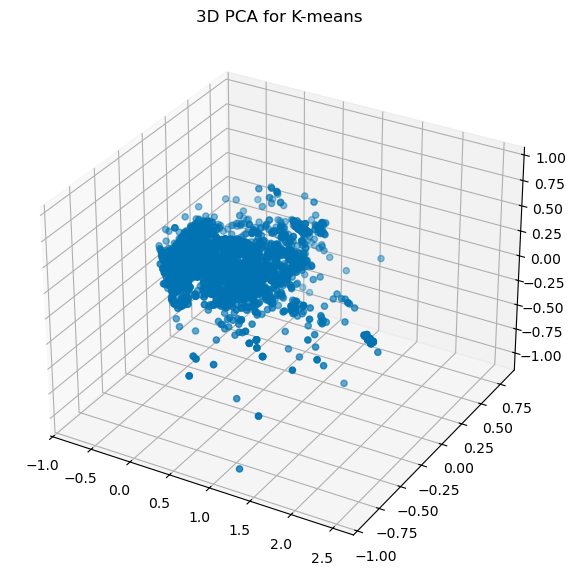

In [219]:
#clusters = df_low_IC50['km_Cluster']
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2])
plt.title("3D PCA for K-means")   
# show plot
plt.show()

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
X, y = df_low_IC50_pd, df_low_IC50['IC50 (nM)']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=42) 

In [207]:
y_test = np.array(y_test).reshape(-1, 1)

In [208]:
lr = RandomForestRegressor()
lr.fit(X_train, y_train)
ypred = lr.predict(X_test)

In [209]:
from sklearn.metrics import mean_absolute_error, r2_score

print(mean_absolute_error(y_test, ypred))
print(r2_score(y_test, ypred))

0.0012990071820439015
-0.07112209826857763


In [169]:
importances = lr.feature_importances_
feature_names = X.columns  # Replace with your actual feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(importance_df)

                                              Feature  Importance
0                           BindingDB Reactant_set_id    0.515610
3                                               MolWt    0.113456
4                                                LogP    0.089072
1                                 BindingDB MonomerID    0.066663
11                                       FractionCSP3    0.059132
7                                                TPSA    0.047966
6                                       NumHAcceptors    0.029653
8                                   NumRotatableBonds    0.026390
13                                       FormalCharge    0.017033
14                                         km_Cluster    0.014162
5                                          NumHDonors    0.010614
12                                          RingCount    0.008918
9                                    NumAromaticRings    0.000770
2   Number of Protein Chains in Target (>1 implies...    0.000311
10        

In [170]:
df_low_IC50

,index,BindingDB Reactant_set_id,BindingDB MonomerID,IC50 (nM),Number of Protein Chains in Target (>1 implies a multichain complex),MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,FormalCharge,km_Cluster
0,0.000000,0.000000e+00,0.000001,4.465887e-07,0.0,0.066157,0.571534,0.048544,0.065217,0.045009,0.059524,0.025,0.047619,0.677419,0.033333,0.75,1
1,0.000033,1.940647e-08,0.000001,9.309980e-06,0.0,0.074270,0.594721,0.048544,0.086957,0.050950,0.067460,0.025,0.047619,0.696970,0.033333,0.75,1
2,0.000067,5.821942e-08,0.000001,8.626157e-06,0.0,0.082382,0.580524,0.048544,0.108696,0.056890,0.083333,0.025,0.047619,0.714286,0.033333,0.75,1
3,0.000100,7.762589e-08,0.000001,3.523790e-06,0.0,0.094285,0.581155,0.048544,0.130435,0.062830,0.107143,0.025,0.047619,0.743590,0.033333,0.75,1
4,0.000133,9.703236e-08,0.000001,1.419721e-06,0.0,0.085623,0.576882,0.058252,0.097826,0.065993,0.067460,0.075,0.047619,0.473684,0.066667,0.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13749,0.999867,9.999567e-01,0.987895,1.052034e-03,0.0,0.038687,0.610883,0.009709,0.054348,0.022172,0.007937,0.050,0.095238,0.500000,0.066667,0.75,0
13750,0.999900,9.999896e-01,0.999998,6.890774e-05,0.0,0.042202,0.605068,0.019417,0.054348,0.027903,0.019841,0.050,0.047619,0.190476,0.050000,0.75,0
13751,0.999933,1.000000e+00,0.000180,2.204012e-07,0.0,0.058979,0.581408,0.019417,0.076087,0.036813,0.047619,0.050,0.047619,0.500000,0.050000,0.75,3
13752,0.999967,1.000000e+00,1.000000,6.306947e-07,0.0,0.057084,0.571257,0.029126,0.065217,0.042876,0.055556,0.050,0.000000,0.440000,0.033333,0.75,0


In [153]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train,X_train)
results = model.fit()
ypr = results.predict(X_test)

In [154]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              IC50 (nM)   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.45
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           2.02e-37
Time:                        21:28:47   Log-Likelihood:                 25155.
No. Observations:               11003   AIC:                        -5.028e+04
Df Residuals:                   10987   BIC:                        -5.016e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    0.0254      0.010      2.515      0.012       0.006       0.045
index                                                                    0.0026      0.001      1.771      0.077      -0.000       0.005
BindingDB Reactant_set_id                                                0.0016      0.008      0.213      0.831      -0.013       0.017
BindingDB MonomerID                                                     -0.0007      0.011     -0.059      0.953      -0.022       0.021
Number of Protein Chains in Target (>1 implies a multichain complex)    -0.0040      0.004     -1.070      0.285      -0.011       0.003
MolWt                                                                    0.0230      0.035      0.657      0.511      -0.046       0.092
LogP                                                                    -0.0195      0.011     -1.722      0.085      -0.042       0.003
NumHDonors                                                              -0.0667      0.026     -2.595      0.009      -0.117      -0.016
NumHAcceptors                                                           -0.0698      0.019     -3.732      0.000      -0.107      -0.033
TPSA                                                                     0.0987      0.046      2.151      0.032       0.009       0.189
NumRotatableBonds                                                        0.0425      0.025      1.668      0.095      -0.007       0.092
NumAromaticRings                                                        -0.0357      0.009     -4.082      0.000      -0.053      -0.019
NumAliphaticRings                                                        0.0128      0.006      1.999      0.046       0.000       0.025
FractionCSP3                                                            -0.0144      0.002     -6.483      0.000      -0.019      -0.010
RingCount                                                               -0.0193      0.005     -3.608      0.000      -0.030      -0.009
FormalCharge                                                            -0.0094      0.009     -1.084      0.279      -0.027       0.008
km_Cluster                                                               0.0022      0.004      0.587      0.557      -0.005       0.009
==============================================================================
Omnibus:                    25613.475   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172622572.528
Skew:                          23.201   Prob(JB):                         0.00
Kurtosis:                  

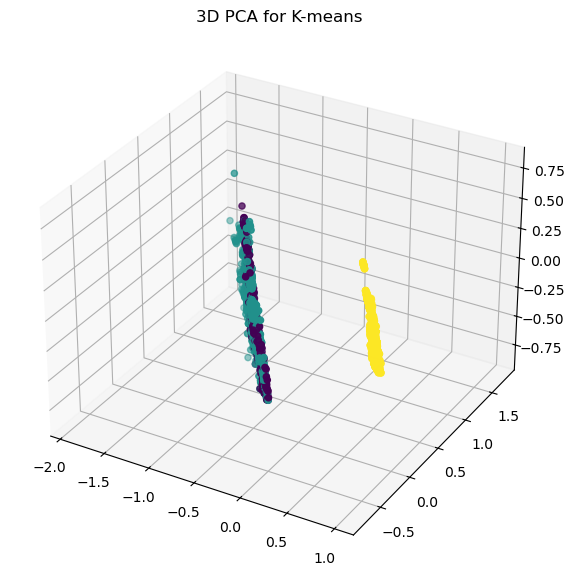

In [113]:
evaluation_utils.plot_pca_3d(df_low_IC50_clustering, clusters_km, kmc=True)

From the PCA we can first notice that the clusters are very well defined and well separated, suggesting that there are four distinct possible molecular 'classes' between high affinity compounds. Wen can notice for all of them an intra-cluster variability along axis Z (third principal component), and really low variability along other axis. For what concenrn inter-class variability, the clusters are well separated along X and Y axis, and less along Z. Still, potentially these clusters can be used as classes in a possible multiclass classification drug prediction.

### Spectral Clustering on Similarity Matrix ###

Now spectral clustering will be applied to the Tanimoto similarity matrix. Because 'normal' elbow method can't be used here, the number of clusters was manually set after some attempts to 4. This clustering can potentially catch even more deep relationships between molecules, being executed on similarity based on morgan fingerprints. The sampled dataframe is now used, as it's the reference for the similarity matrix

In [31]:
k = 4  # Number of clusters, also here chosen based on above elbow method (not completely correct but still tried)
spc = SpectralClustering(n_clusters=k, random_state=42, affinity='precomputed')
clusters_sp = spc.fit_predict(similarity_matrix)
df_sample['sm_Cluster'] = clusters_sp
print(df_sample.groupby('sm_Cluster').size())  #clusters size

sm_Cluster
0    1220
1    3083
2     140
3     557
dtype: int64


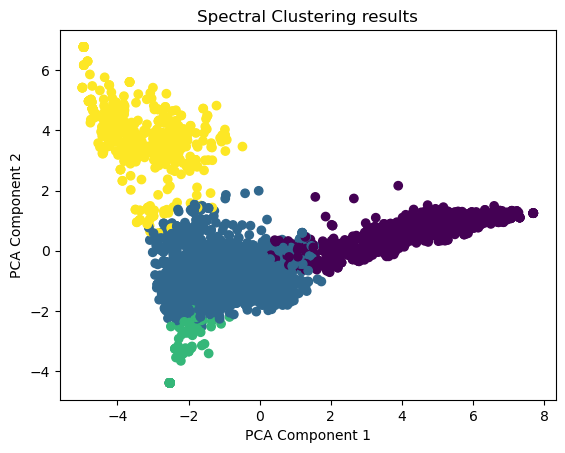

In [32]:
evaluation_utils.plot_pca_2d(similarity_matrix, clusters_sp, kmc=False)

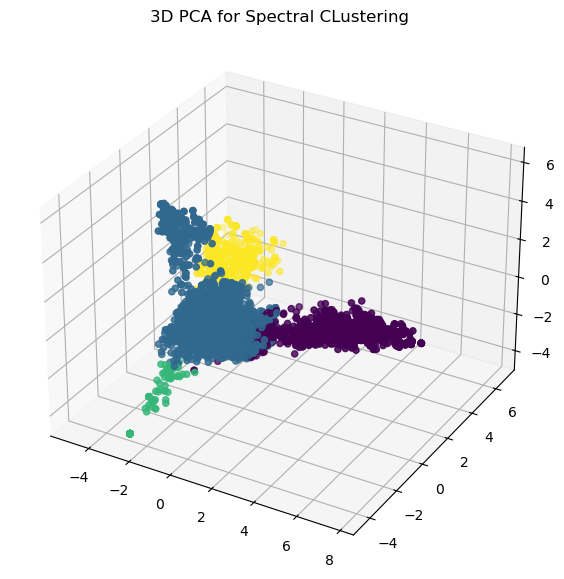

In [33]:
evaluation_utils.plot_pca_3d(similarity_matrix, clusters_sp, kmc=False)

We can see that the data are in 4 distinct and not too overlapped clusters. But what does this mean?
First of all, a little recap of how these data were obtained. The initial dataframe was filtered to include just high-affinity ligands (with IC50 below 0.00017, saw from the distribution plot). Then, Morgan fingerprints of such compounds were extracted, and a similarity matrix between them was computed. The similarity metric is the 'tanimoto' score, where 1 indicates perfectly overlapping bits and 0 totally different.
Then, spectral clustering is applied to this matrix, as K-means is not the best choice for a similarity matrix. These visualizations are an indication of the fact that maybe the complexity of morgan fingerprints led to less separated clusters, also remembering that the original dimensions were 5000, now reduced to 2 or 3, so it's possible that the classes are more separate in higher dimensions. Still, this is another interesting molecular subdivision based on their structure, rather than on previously tested molecular features

In [22]:
####OTHER METRICS: DICE AND COSINE 
similarities_dice, similarity_matrix_dice =  rdkit_extraction.compute_dice_similarities(df_sample)

<Axes: >

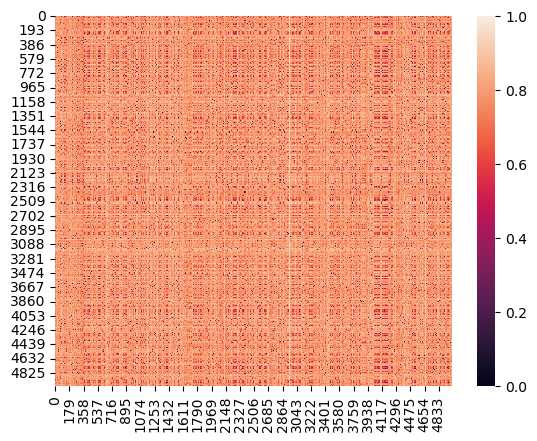

In [23]:
sns.heatmap(similarity_matrix_dice)


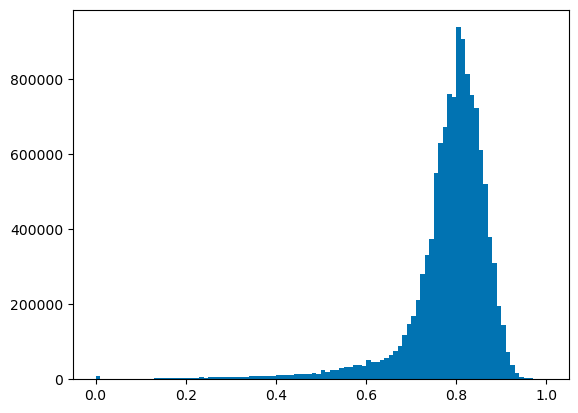

In [24]:
plt.hist(similarities_dice, bins=100)
plt.show()

In [26]:
from sklearn.cluster import KMeans,SpectralClustering
k = 4  # Number of clusters, also here chosen based on above elbow method (not completely correct but still tried)
spc = SpectralClustering(n_clusters=k, random_state=42, affinity='precomputed')
clusters_sp_dc = spc.fit_predict(similarity_matrix_dice)
df_sample['sm_Cluster_dc'] = clusters_sp_dc
print(df_sample.groupby('sm_Cluster_dc').size())  #clusters size

c:\Users\Utente\anaconda3\envs\ada_proj\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 12 with accuracies 
[3.51285284e-15 6.56410979e-05 6.76324584e-05 8.21703789e-05
 6.93582422e-05]
not reaching the requested tolerance 7.450580596923828e-05.
Use iteration 12 instead with accuracy 
5.6960435467568834e-05.

  _, diffusion_map = lobpcg(
c:\Users\Utente\anaconda3\envs\ada_proj\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[3.51424753e-15 6.56410979e-05 6.76324584e-05 8.21703789e-05
 6.93582422e-05]
not reaching the requested tolerance 7.450580596923828e-05.
  _, diffusion_map = lobpcg(


sm_Cluster_dc
0    1211
1    1275
2    1232
3    1282
dtype: int64


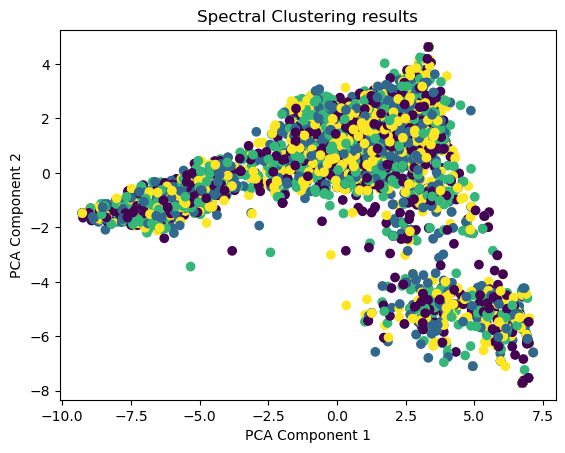

In [27]:
evaluation_utils.plot_pca_2d(similarity_matrix_dice, clusters_sp_dc, kmc=False)

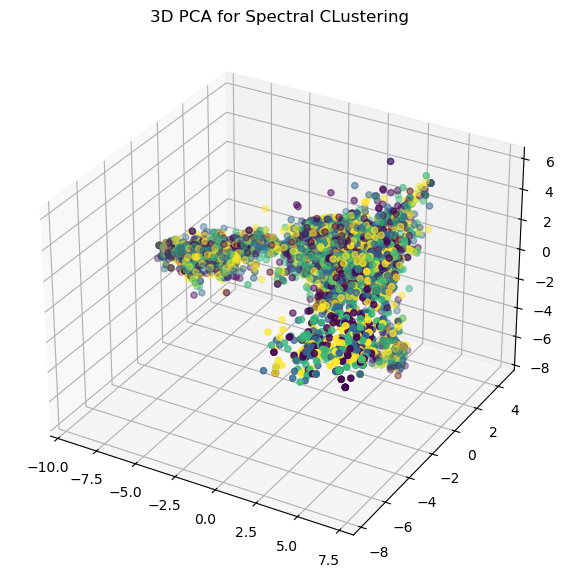

In [28]:
evaluation_utils.plot_pca_3d(similarity_matrix_dice, clusters_sp_dc, kmc=False)

In [35]:
hivcl2 = hiv.copy()

In [36]:
hivcl2.columns

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'IC50 (nM)', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'Authors', 'Institution',
       'Link to Ligand in BindingDB', 'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'PubChem CID', 'PubChem SID',
       'ZINC ID of Ligand',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain',
       'UniProt (TrEMBL) Submitted Name of Target Chain',
       'UniProt (TrEMBL) Entry Name of Target Chain',
       'UniProt (TrEMBL) Primary ID of Target Chain'],
      dtype='object')

In [42]:
hivRD.columns

Index(['index', 'BindingDB Reactant_set_id', 'Ligand SMILES',
       'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'IC50 (nM)', 'Curation/DataSource', 'BindingDB Entry DOI',
       'Link to Ligand in BindingDB', 'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'Mol', 'MolWt', 'LogP', 'NumHDonors',
       'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings',
       'NumAliphaticRings', 'FractionCSP3', 'RingCount', 'FormalCharge',
       'NumRadicalElectrons', 'Mol'],
      dtype='object')

In [43]:
def nan_to_numeric2(df):
    df = df.reset_index()
    # Select columns that contain NaNs
    columns_with_nans_nn = df.columns[df.isna().any()]

    # Convert columns with NaNs to np.float64 if they contain only numeric values or NaNs
    for col in columns_with_nans_nn:
        if df[col].apply(lambda x: isinstance(x, (int, float)) or pd.isna(x)).all():
            # Convert column to np.float64
            df[col] = df[col].astype(np.float64)
    columns = ['UniProt (TrEMBL) Submitted Name of Target Chain',
            'UniProt (TrEMBL) Entry Name of Target Chain',
            'UniProt (TrEMBL) Primary ID of Target Chain',
            'ZINC ID of Ligand',
            'PDB ID(s) of Target Chain',
            'PMID',
            'Article DOI',
            'Institution',
            'Authors',
            'Ligand InChI',
            'PubChem CID',
            'PubChem SID']
    df = df.drop(columns=columns)
    df = df.dropna()
    return df

In [118]:
hivRD2 = nan_to_numeric2(hivcl2)
# Convert SMILES to RDKit Mol objects
hivRD2['Mol'] = hivRD2['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)

# Calculate descriptors and add them to the DataFrame
descriptor_df2 = hivRD2['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD2 = pd.concat([hivRD2, descriptor_df2], axis=1)

# Calculate fingerprints and add them to the DataFrame
fingerprint_df2 = hivRD2['Mol'].apply(lambda mol: rdkit_extraction.calculate_morgan_fingerprint(mol))
hivRD2 = pd.concat([hivRD2, fingerprint_df2], axis=1)

numerical_df2, non_numerical_df2 = data_utils.separe_num_df(hivRD2)
numerical_df2 = (numerical_df2 - numerical_df2.min())/(numerical_df2.max() - numerical_df2.min())
numerical_df2 = numerical_df2.drop(columns=['NumRadicalElectrons']) #column dropped as it was all 0-valued
non_numerical_df2['index'] = numerical_df['index']
#Now we can filter the data including only high affinity ligands with the above mentioned threshold
df_low_IC502 = numerical_df2[numerical_df2['IC50 (nM)'] < 0.00017]

In [119]:
# Filter the dataset to include only rows with Ligand InChI Key present in drug_class_dict
lwic502 = non_numerical_df2[non_numerical_df2['Ligand InChI Key'].isin(drug_class_dict.keys())].copy()

# Adding a new column 'Drug_Class' with the drug class based on the dictionary
lwic502['Drug_Class'] = lwic502['Ligand InChI Key'].map(drug_class_dict)

# Addinga new column 'drug_name' using .loc to avoid the SettingWithCopyWarning
lwic502.loc[:, 'drug_name'] = lwic502['Ligand InChI Key'].map(drug_name_dict)

In [120]:
lwic502 = lwic502.loc[:, ~lwic502.columns.duplicated()]
#non_numerical_df_lowIC50 = lwic502.loc[df_low_IC50.index]

In [121]:
filtered_lwic502 = df_low_IC502[df_low_IC502['index'].isin(lwic502['index'])]

In [122]:
filtered_lwic502.columns

Index(['index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID',
       'IC50 (nM)',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA',
       'NumRotatableBonds', 'NumAromaticRings', 'NumAliphaticRings',
       'FractionCSP3', 'RingCount', 'FormalCharge'],
      dtype='object')

In [157]:
mapclass = {
    'PI' : 1,
    'RTI (NNRTI)': 2,
    'RTI (NRTI)': 3,
    'INSTI' : 4
}
lwic502['class_num'] = lwic502['Drug_Class'].map(mapclass)

In [158]:
lwic502f = lwic502[lwic502['index'].isin(filtered_lwic502['index'])]

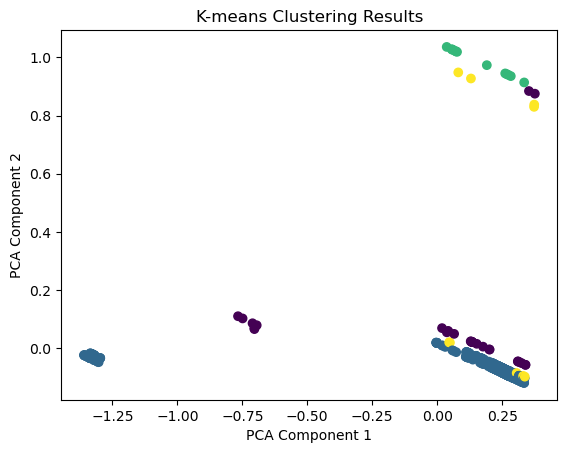

In [159]:
evaluation_utils.plot_pca_2d(filtered_lwic502, lwic502f['class_num'], kmc=True)


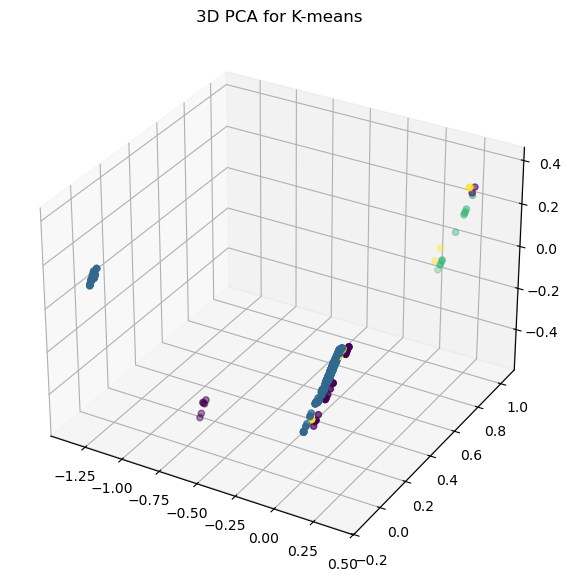

In [160]:
evaluation_utils.plot_pca_3d(filtered_lwic502, lwic502f['class_num'], kmc=True)

In [175]:
def create_df_mf2(df, df_low, lends):
    np.random.seed(469875)
    mask = np.random.choice(a = len(df_low), size=(lends,), replace=False)
    cols = ['Ligand SMILES', 'BindingDB Ligand Name', 'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'Curation/DataSource', 'BindingDB Entry DOI',
       'Link to Ligand in BindingDB', 'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB',
       'BindingDB Target Chain Sequence', 'Mol', 'Morgan_f', 'Mol',
       'Morgan_f']
    df.columns = cols
    df = df.loc[:, ~df.columns.duplicated()]
    non_numerical_df_lowIC50 = df.loc[df_low.index]
    df_sample = non_numerical_df_lowIC50.iloc[mask]
    return df_sample

In [177]:
dfsample3 = create_df_mf2(non_numerical_df, df_low_IC50, lends=len(df_low_IC50))

In [181]:
similarities2, similarity_matrix2 = rdkit_extraction.compute_tanimoto_similarities(dfsample3)

In [183]:
similarity_matrix2.shape

(531, 531)

check similar mol

In [184]:
sim2 = similarity_matrix2.copy()

In [185]:
# Exclude the diagonal by setting it to a very small value (or -infinity)
np.fill_diagonal(sim2, -np.inf)

# Extract the upper triangular part, excluding the diagonal
triu_indices = np.triu_indices_from(sim2, k=1)  # k=1 excludes the diagonal
upper_tri_values = sim2[triu_indices]

# Filter for values less than 1
valid_mask = upper_tri_values < 1
valid_values = upper_tri_values[valid_mask]
valid_row_indices = triu_indices[0][valid_mask]
valid_col_indices = triu_indices[1][valid_mask]

# Find indices of the top 10 largest values less than 1
top_10_indices = np.argpartition(valid_values, -20)[-20:]
sorted_top_10_indices = top_10_indices[np.argsort(valid_values[top_10_indices])][::-1]

# Map back to 2D indices in the original matrix
row_indices = valid_row_indices[sorted_top_10_indices]
col_indices = valid_col_indices[sorted_top_10_indices]

# Get the top 10 values and their indices
top_10_values = valid_values[sorted_top_10_indices]
top_10_positions = list(zip(row_indices, col_indices))

print("Top 10 values:", top_10_values)
print("Top 10 indices:", top_10_positions)

Top 10 values: [0.96774194 0.96774194 0.96774194 0.96774194 0.96774194 0.96774194
 0.96774194 0.96774194 0.95698925 0.95604396 0.95604396 0.95604396
 0.95604396 0.95604396 0.95604396 0.94680851 0.94680851 0.94680851
 0.94680851 0.94680851]
Top 10 indices: [(np.int64(204), np.int64(527)), (np.int64(32), np.int64(527)), (np.int64(198), np.int64(527)), (np.int64(34), np.int64(527)), (np.int64(131), np.int64(527)), (np.int64(2), np.int64(527)), (np.int64(385), np.int64(527)), (np.int64(517), np.int64(527)), (np.int64(87), np.int64(155)), (np.int64(251), np.int64(263)), (np.int64(65), np.int64(450)), (np.int64(65), np.int64(251)), (np.int64(251), np.int64(426)), (np.int64(426), np.int64(450)), (np.int64(263), np.int64(450)), (np.int64(243), np.int64(325)), (np.int64(188), np.int64(325)), (np.int64(95), np.int64(188)), (np.int64(95), np.int64(243)), (np.int64(43), np.int64(95))]


In [187]:
#check first pair
df_sample2 = dfsample3.reset_index()

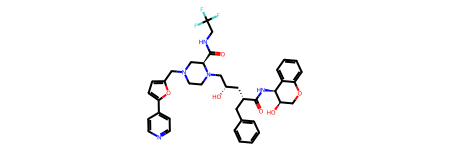

In [210]:
df_sample2.loc[251]['Mol']

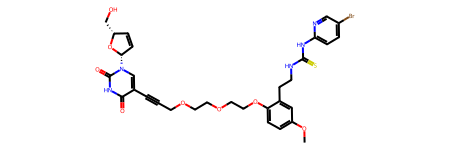

In [131]:
df_sample2.loc[3845]['Mol']

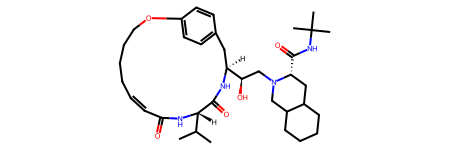

In [132]:
df_sample2.loc[977]['Mol']

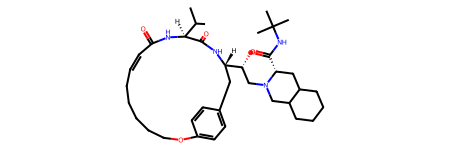

In [133]:
df_sample2.loc[1807]['Mol']

In [103]:
df_sample2.loc[1807]

index                                                                                                     7157
Ligand SMILES                                                CC(C)[C@@H]1NC(=O)\C=C/CCCCCOc2ccc(C[C@H](NC1=...
BindingDB Ligand Name                                        (6S,7S,8aS)-2-[(R)-2-Hydroxy-2-((Z)-(1S,12S)-1...
Target Name                                                                      Gag-Pol polyprotein [489-587]
Target Source Organism According to Curator or DataSource                       Human immunodeficiency virus 1
Curation/DataSource                                                                                     ChEMBL
BindingDB Entry DOI                                                                           10.7270/Q2PG1RP3
Link to Ligand in BindingDB                                  http://www.bindingdb.org/bind/chemsearch/marvi...
Link to Target in BindingDB                                  http://www.bindingdb.org/jsp/dbsearch/PrimaryS...
L